# EE3020: Classifying Heart Disease

# 1. Introduction:

A number of feature selection methods and models are evaluated in this notebook to try and produce the best performance on the heart disease dataset. Feature selection has 2 main benefits: it reduces the dimensionality of the dataset and in some cases can actually improve the performance of a model, particularly when noisey or uninformative features are present.

### Performance Benchmark:
A benchmark model consisting of a Gaussian kernel SVM using all features in the dataset is evaluated first. This is done to generate some results that can be used as a baseline to compare the efficacy of the feature selection methods used later. 

The Gaussian kernel SVM is used because it's a popular non-linear classification model which is well suited to small and medium size data sets. This is because the decision boundary of the SVM is determined by a small number of instances from the dataset - the support vectors, which are the data instances in each class that are “closest” to instances of the other class. Adding easily-classified instances to the dataset (i.e. that are not support vectors) does not have any effect on the model's decision boundary.

### Filter Methods:
Filter-based feature selection methods use some statistical analysis of the features to determine which are the best to use for a given classification problem. It is a 'model agnostic'/'model independent' feature selection method as a result. 

For this problem, the Area Under the ROC Curve (AUC), which is a measure of the separability of the classes for a given feature, is used to determine the best performing numerical features. The ANOVA correlation coefficient, which measures the linear correlation between a numerical variable and a categorical label, is also used to assess the correlation between the numerical features and the target classes. These 2 metrics are used to select the best performing numerical features. The feature correlation matrix is also computed to identify any highly correlated or redundant numerical features.

Mutual information, which is a measure of the correlation between 2 categorical variables, is used to determine the categorical features that have the highest correlation with the target label. It's also used to check for any highly correlated (redundant) categorical features.

Using these measures, 10 features from the (encoded) feature set are selected and used to train and evaluate a Gaussian kernel SVM.

### Embedded Methods:
Embedded feature selection methods are carried out by a machine learning model during training, and are usually specific to the model e.g. Lasso (L1) regression and Random Forest classifiers. For this application, Random Forests (which are a powerful non-linear classification model) are used to carry out embedded feature selection. The most important features as determined by the Random Forest classifier are also assessed.

### Wrapper Methods:
Wrapper feature selection models use a machine learning model to evaluate the importance of the features. It is distinct from embedded methods as usually wrapper techniques can be applied to various different models, whereas embedded methods are specific to a particular model, as mentioned earlier. Recursive Feature Elimination (RFE) is carried out with a linear SVM to determine the subset of features that maximise the performance of the linear SVM - this approach considers the subset of features that work together to produce the best performance rather than considering each feature individually, which is a potential drawback of the univariate filter-based feature selection methods.

### Overview of Methodology:

As SVMs are used in this notebook, the numerical features are standardised to have a mean of 0 and standard deviation of 1 (SVMs prefer features to have the same scale). 

The nominal categorical features are One Hot Encoded (binary categorical features are left unchanged). The benefits of encoding are explained later in the notebook.

The models are evaluated using a 'Leave 30 Out'/10-fold performance evaluation which is outlined later on in the notebook. This is a robust method of evaluating models, as the models are tested on the entire dataset, reducing the chance of a 'lucky split' occurring in the test set and producing overly-optimistic results. The mean AUC and accuracy, as well as the standard deviation of the AUC and accuracy are reported at the end of the evaluation. The AUC is a good measure of how well the classifier is able to distinguish between the classes and the accuracy tells us the ratio of correct predictions made by the classifier.

The Receiver Operating Characteristic (ROC) curve is reported. This is directly related to the AUC. The ROC is useful in choosing a particular decision threshold for a classifier to modify how sensitive it is to the confidence scores/probabilities output by the model. This is important in a medical context, where you don't want a highly sensitive classifier which produces lots of false positives (and hence the results may eventually be ignored) but you also don't want a classifier which misses subjects that have a health problem or illness.

The confusion matrix and precision & recall of the model's predictions are also reported, which are useful metrics for assessing a binary classifier's performance. The precison of a classifier represents the accuracy of the classifier's positive predictions, while the recall measures the ratio of correctly identified positive classes. The importance of the precision metric for this particular problem is outlined in the final discussion of results.

# 2. Import libraries:

In [1]:
import pandas as pd # Import pandas library for data manipulation.
import numpy as np # Import numpy to use np arrays in sklearn models.
import matplotlib.pyplot as plt # Import matplotlib for generating plots.
import seaborn as sns # Import seaborn to make nice plots.
from sklearn.model_selection import GridSearchCV # Import sklearn's GridSearchCV to perform k-fold cross validation.
from sklearn.svm import SVC # Import Support Vector Machine model.
from sklearn.metrics import roc_auc_score # Calculate AUC of individual features and classifiers.
from sklearn.metrics import roc_curve # Generate Receiver Operating Characteristic curve.
from sklearn.feature_selection import f_classif # Calculate ANOVA correlation coefficient.
from sklearn.preprocessing import OneHotEncoder # Perform One Hot Encoding of categorical features.
from sklearn.feature_selection import mutual_info_classif # Calculate mutual information between 2 variables.
from sklearn.preprocessing import StandardScaler # Standardise feature set (mean = 0, std = 1).
from sklearn.metrics import accuracy_score # Calculate the accuracy of a classifier's predictions.
from sklearn.metrics import make_scorer # Convert accuracy_score to a scorer function that can be used in multi-metric evaluation for gridsearch.
from sklearn.ensemble import RandomForestClassifier # Import Random Forests Classifier for embedded feature selection.
from sklearn.model_selection import StratifiedKFold # Perform a stratified train/test split for 'Leave 30 Out' performance evaluation.
from sklearn.feature_selection import RFE # Import recursive feature elimination wrapper for SVM.
from sklearn.metrics import confusion_matrix # Automatically construct confusion matrix given true labels and classifier predictions.
from sklearn.metrics import precision_score # Calculate the precision of the classifier using its predictions on the test set.
from sklearn.metrics import recall_score # Calculate the recall (true positive rate) of the classifier using its predictions on the test set.
from sklearn.metrics import precision_recall_curve # Plot precision and recall as a function of classifier decision threshold.

# 3. Import data:

In [2]:
raw_data = pd.read_csv('heart.csv') # Import heart csv as pandas dataframe.
raw_data # Inspect raw data.

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [3]:
labels = raw_data.target # Extract labels from target column.
feats = raw_data.drop(columns='target') # Remove labels to extract only the feature data.
feats # Inspect feature data.

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [4]:
feats.info() # Inspect dataframe dtypes and check if there is any NaNs in the data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 30.9 KB


# 4. Prepare the data for machine learning models:

**Numerical variables:** `age`, `trestbps`, `chol`, `thalach`, `oldpeak`, `ca`.

Depending on the model, the numerical features may need to be scaled. I'm going to be evaluating Support Vector Machines (SVMs) and Random Forests. SVMs require the features to be scaled (as the SVM decision boundary construction relies on the distance between feature vectors), but Random Forests do not - that said, the RF performance won't decrease if the features are scaled so I'll scale all the numerical features for convenience.

**Dichotomous/Binary categorical variables:** `sex`, `fbs`, `exang`.

Binary variables don't need to be encoded, it's more efficient to keep them in a single column/feature.

**Nominal categorical variables:** `cp`, `restecg`, `slope`, `thal`.

Nominal categorical variables need to be one hot encoded.

Ordinal categorical variables assume that their is some ordering in the numbers assigned to them. For example, for `thal`, ordinal would assume that NULL (0) is worse than Fixed defect (1) which is worse than normal blood flow (2) and so on. However, I lack the domain knowledge to know whether this is the case and so I'll treat them as nominal categorical variables.

## Scale numerical features:

Standardisation brings the numerical features down to the same scale, by subtracting the mean and dividing by the standard deviation of that feature. This results in all features having a mean of 0 and a standard deviation of 1. When .fit is called for the StandardScaler transformer it calculates the means and stds for each feature. The .transform method takes the data set and standardises it using the means and stds calculated during the fit. The .fit_transform method carries out both of these steps in 1 go.

**Documentation for StandardScaler:** https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [5]:
num_feats = feats.loc[:,['age','trestbps','chol','thalach','oldpeak','ca']] # Extract numerical features from df.
num_feats # Inspect numerical feats.

,age,trestbps,chol,thalach,oldpeak,ca
0,63,145,233,150,2.3,0
1,37,130,250,187,3.5,0
2,41,130,204,172,1.4,0
3,56,120,236,178,0.8,0
4,57,120,354,163,0.6,0
...,...,...,...,...,...,...
298,57,140,241,123,0.2,0
299,45,110,264,132,1.2,0
300,68,144,193,141,3.4,2
301,57,130,131,115,1.2,1


In [6]:
num_feats.ca.unique() # Check the range of values for 'ca' feature.

array([0, 2, 1, 3, 4], dtype=int64)

In [7]:
std_scaler = StandardScaler() # Initialise StandardScaler transformer, which standardises the data to have mean = 0 and std = 1.
num_feats_scaled = std_scaler.fit_transform(num_feats) # Fit scaler to numerical features (calculate means and stds) and then transform (scale) the data.
num_feats_scaled = pd.DataFrame(num_feats_scaled,columns = num_feats.columns) # Convert scaled numerical feats from numpy array to dataframe.
num_feats_scaled # Inspect scaled numerical features.

,age,trestbps,chol,thalach,oldpeak,ca
0,0.952197,0.763956,-0.256334,0.015443,1.087338,-0.714429
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,-0.714429
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,-0.714429
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,-0.714429
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,-0.714429
...,...,...,...,...,...,...
298,0.290464,0.478391,-0.101730,-1.165281,-0.724323,-0.714429
299,-1.033002,-1.234996,0.342756,-0.771706,0.138373,-0.714429
300,1.503641,0.706843,-1.029353,-0.378132,2.036303,1.244593
301,0.290464,-0.092738,-2.227533,-1.515125,0.138373,0.265082


## Encode the nominal categorical features:

In [8]:
cat_feats = feats.loc[:,['sex','fbs','exang','cp','restecg','slope','thal']] # Separate categorical features.
cat_feats # Inspect dataframe

,sex,fbs,exang,cp,restecg,slope,thal
0,1,1,0,3,0,0,1
1,1,0,0,2,1,0,2
2,0,0,0,1,0,2,2
3,1,0,0,1,1,2,2
4,0,0,1,0,1,2,2
...,...,...,...,...,...,...,...
298,0,0,1,0,1,1,3
299,1,0,0,3,1,1,3
300,1,1,0,0,1,1,3
301,1,0,1,0,1,1,3


One hot encoding transforms a categorical feature with N categories into N individual binary features. For example, `cp` has 4 categories: 0,1,2,3. One hot encoding will transform `cp` into 4 features: `cp_0`, `cp_1` etc, where `cp_0` is a feature with 1s where `cp` was 0 for a particular subject and 0s everywhere else. The argument `handle_unkown='ignore'` ensures that any categories that appear in the test set that were not in the training set will not cause an error, and instead be assigned to a column of all 0s.

One hot encoding is carried out because if the categorical data is not ordinal (i.e. it's nominal categorical data), a machine learning model might assume that 2 close-by labels (e.g. 4 and 5) mean that the 2 labels are similar when this may not be the case - for example it might assume for `cp` that asymptomatic (0) and atypical angina (1) are more similar than atypical angina (1) and typical angina (3).

**Documentation for OneHotEncoder:** https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [9]:
OHE = OneHotEncoder(handle_unknown='ignore') # Initialise OneHotEncoder transformer.
OHE_cat_feats = OHE.fit_transform(cat_feats.loc[:,['cp','restecg','slope','thal']]).toarray() # Fit OHE to nominal categorical features, and convert the output to a numpy dense array.
OHE_cat_feats = pd.DataFrame(OHE_cat_feats,columns = OHE.get_feature_names(['cp','restecg','slope','thal'])) # Create a dataframe from the encoded features with the feature names as prefixes to the encoded feats.
OHE_cat_feats # Inspect dataframe.

,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
299,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
300,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
301,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [10]:
cat_feats = pd.concat([cat_feats.drop(columns=['cp','restecg','slope','thal']),OHE_cat_feats],axis=1) # Concatenate the binary categorical feats and the one hot encoded feats into 1 dataframe.
cat_feats # Inspect dataframe.

,sex,fbs,exang,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,1,1,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
299,1,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
300,1,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
301,1,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# 5. Establishing a benchmark performance:

A Gaussian kernel SVM using all 13 features (i.e. no feature selection is performed) is used as a performance benchmark. 

The Gaussian kernel SVM projects the data to a higher dimensional space using the Radial Basis Function as a mapping function (although the kernel trick means this mapping doesn't actually have to be carried out in practice). The SVM then seeks to implement the decision boundary with the largest margin between the classes in this higher dimensional space. The support vectors, mentioned earlier, determine the decision boundary and margin. The `gamma` hyperparameter is a parameter of the RBF, while the `C` hyperparameter is a regularisation hyperparameter which determines how many training instances are allowed to violate the margin around the decision boundary.

## Prepare the data for the SVM:

The scaled numerical and encoded categorical features are combined into 1 dataframe for the SVM.

In [11]:
feats_prepared = num_feats_scaled.join(cat_feats) # Join the numerical and categorical features dataframe. Identical functionality to .concat() when the 2 dataframes have the same index.
feats_prepared # Inspect the resulting dataframe.

,age,trestbps,chol,thalach,oldpeak,ca,sex,fbs,exang,cp_0,...,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,0.952197,0.763956,-0.256334,0.015443,1.087338,-0.714429,1,1,0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,-0.714429,1,0,0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,-0.714429,0,0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,-0.714429,1,0,0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,-0.714429,0,0,1,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.290464,0.478391,-0.101730,-1.165281,-0.724323,-0.714429,0,0,1,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
299,-1.033002,-1.234996,0.342756,-0.771706,0.138373,-0.714429,1,0,0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
300,1.503641,0.706843,-1.029353,-0.378132,2.036303,1.244593,1,1,0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
301,0.290464,-0.092738,-2.227533,-1.515125,0.138373,0.265082,1,0,1,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Run a 10-fold Performance Evaluation using all numerical and categorical features:

A 'Leave 30 Subjects Out' or 10-Fold Performance Evaluation is used to assess the performance of each classifier used in this assignment. The data is split into 10 folds. 9 of these folds are used for training and cross validation - a 5 fold cross validation is carried out on the 9 folds to determine the pair of hyperparameters that maximise the performance of the model on the 9 folds. The model is then trained on the 9 folds and makes predictions on the 10th fold. This procedure ensures that the subjects in the test fold are not seen by the classifier at any time during training. This process is repeated until all 10 folds have been used as a test fold. The most common pair of hyperparameters selected across the 10 iterations, as well as the AUCs and accuracy scores across the 10 test folds are reported at the end and used to evaluate the overall performance of the model.

If this system were being developed for actual use, either an ensemble of the 10 SVMs used for the 10 test folds would be used as the final model, or the most common hyperparameters would be selected to train the SVM over all 303 subjects in the dataset.

This is a robust method for testing each classifier as the chance of a 'lucky split' occurring for the test set is minimised by using 10 unique test sets. Each subject in the test fold is not used for training or tuning the model hyperparameters so it is a subject independent performance evaluation.

StratifiedKFold is used to make a stratified 10 fold split - i.e. the balance of the classes is maintained across the 10 test folds created.

GridSearchCV is used to perform a 5 fold cross validation on the 9 training folds at each iteration. The model is trained with a given set of hyperparameters on the 4 CV folds and tested on the left out 5th CV fold. This process is repeated until each CV fold has been used as the test fold. This process is repeated for all hyperparameters being tested. The hyperparameters with the best mean performance across the 5 CV folds are returned.

The multi-metric scoring is necessary to evaluate both the AUC and accuracy on each CV fold.

roc_auc_score computes the AUC of a classifier given the actual labels and the classifier's corresponding scores or probabilities for each label.

accuracy_score simply computes the ratio of correct predictions made by a classifier given the labels and the classifier's corresponding predictions.

**Documentation for StratifiedKFold:** https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

**Documentation for GridSearchCV:** https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

**Code for multi-metric scoring is taken from:** https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html

**Documentation for roc_auc_score:** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

**Documentation for accuracy_score:** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

In [12]:
%%time
n_test_folds = 10 # Number of test folds to create.
n_cv_folds = 5 # Number of folds in the internal hyperparameter cross validation.

param_grid = {'gamma':[0.001,0.01,0.1,1,10,100],
              'C':[0.001,0.01,0.1,1,10,100]} # Define the values of the hyperparameters C and gamma to search over.

scoring = {'AUC': 'roc_auc',
        'Accuracy': make_scorer(accuracy_score)} # Define the multi-metric scoring to use in the gridsearch (AUC and accuracy).

test_CV = StratifiedKFold(n_splits = n_test_folds, shuffle=True, 
                          random_state=0) # Initialise the Stratified/Shuffle/Split for the 10 folds. random_state = 0 ensures the same test folds are used for each run.

test_counter = 0 # Tracks the current test fold number.

best_CV_hyperparams = [] # Stores the optimal set of hyperparameters based on the internal cross validation.
AUCs = [] # Stores AUCs from each of the 10 test folds.
accuracy_scores = [] # Stores accuracy scores from each of the 10 test folds.

# The following lists save results from the 10 folds so that metrics like the ROC can be computed:
test_labels_saved = [] # Saves the test labels in the order in which they appeared in test folds.
BM_test_proba_preds = []  # Saves the benchmark probability predictions in the order in which they were completed in test folds.
BM_test_preds_saved = [] # Saves the benchmark predictions in the order in which they were completed in test folds.


for train_idx,test_idx in test_CV.split(feats_prepared,labels):
    # ================= Model Evaluation Loop =================
    # In this loop, n_test_folds - 1 folds are used as training data, while the remaining
    # fold is used as test data. No data from subjects in the training data appear in the test data
    # and vice versa. A stratified shuffle split is done, such that the class distribution in the test set is preserved
    # when possible.
    # The RBF kernel SVM is trained using the best parameters from the internal CV,
    # and the AUC and accuracy is computed for each test subject in the test fold.
    # =========================================================

    # Extract the training and test data for this iteration's test fold:
    training_set, test_set = feats_prepared.iloc[train_idx,:], feats_prepared.iloc[test_idx,:]
    training_labels, test_labels = labels.values[train_idx], labels.values[test_idx]
    
    svm_clf = SVC(kernel='rbf', probability=True) # Initialise an RBF kernel SVM estimator. 
                                    # probability=True allows the SVM to output a probability of a given class which can
                                    # be used to compute the AUC.

    # Gridsearch uses 5 fold cross validation for the SVM and hyperparameter values defined above. Both the accuracy and AUC
    # are used as the scoring metric. The model with the best mean AUC across the 5 folds is selected and then retrained
    # over all 5 CV folds. n_jobs=-1 uses all processors available to run the gridsearch in parallel, speeding it up.
    grid_search = GridSearchCV(svm_clf, param_grid, cv=n_cv_folds, scoring=scoring,
                           verbose=0, refit='AUC', n_jobs=-1)
    grid_search.fit(training_set.values,training_labels) # Run the gridsearch on the training data for this iteration.
    
    print('\n===== {} of {} evaluations ====='.format(test_counter+1,n_test_folds))
    print('Best hyperparameters from 5-fold CV: {}'.format(grid_search.best_params_)) # Print the best set of hyperparameters.
    print('Best validation AUC achieved: {}'.format(grid_search.best_score_)) # Print the best mean AUC across 5 CV folds.
    
    best_C, best_gamma = grid_search.best_params_['C'], grid_search.best_params_['gamma'] # Extract best C and gamma hyperparams from the CV.
    best_CV_hyperparams.append((best_C,best_gamma)) # Stores the best performing pair of hyperparameter values from CV for this iteration.
    
    best_SVM = grid_search.best_estimator_ # Intialise the best performing SVM from the CV. 
                                           # refit='AUC' means the SVM with the best AUC was refit to all training data used in the gridsearch.
    
    test_proba = best_SVM.predict_proba(test_set)[:,1] # Return probability of class 1 (healthy) for test subjects.
    test_preds = best_SVM.predict(test_set) # Return class predictions (used for accuracy).
    
    test_labels_saved = np.append(test_labels_saved, test_labels) # Save labels from this test fold.
    BM_test_proba_preds = np.append(BM_test_proba_preds, test_proba) # Save probability predictions from this test fold.
    BM_test_preds_saved = np.append(BM_test_preds_saved, test_preds) # Save class predictions from this test fold.
    
    accuracy = accuracy_score(test_labels,test_preds) # Return accuracy of SVM on this test fold.
    AUC = roc_auc_score(test_labels,test_proba) # Return AUC of SVM on this test fold.
    accuracy_scores.append(accuracy) # Save the accuracy for this test fold.
    AUCs.append(AUC) # Save the AUC for this test fold.
    
    print('AUC across test set: {}'.format(AUC)) # Print AUC for this test fold.
    print('Accuracy across test set: {}'.format(accuracy)) # Print accuracy for this test fold.
    
    test_counter += 1 # Increment variable that counts the test fold iterations.

# Counts the tuples of (C,gamma) in best_CV_hyperparams and returns the tuple with the highest count,
# i.e. it returns the (C,gamma) pair that were selected most frequently during the internal
# 5 fold CV:
mode_C,mode_gamma = max(set(best_CV_hyperparams), key=best_CV_hyperparams.count) 

print('\n===== Final Performance Across All Subjects =====')
print('Mean AUC across all test folds: {:.2f}'.format(np.mean(AUCs)))
print('Standard Deviation of AUC across all test folds: {:.2f}'.format(np.std(AUCs)))
print('Median of AUC across all test folds: {:.2f}'.format(np.median(AUCs)))
print('Interquartile Range of AUC across all test folds: {:.2f}'.format(np.subtract(*np.percentile(AUCs, [75, 25]))))
print('\nMean accuracy across all test folds: {:.2f}'.format(np.mean(accuracy_scores)))
print('Standard Deviation of accuracy across all test folds: {:.2f}'.format(np.std(accuracy_scores)))
print('Median of accuracy across all test folds: {:.2f}'.format(np.median(accuracy_scores)))
print('Interquartile Range of accuracy across all test folds: {:.2f}'.format(np.subtract(*np.percentile(accuracy_scores, [75, 25]))))
print('\nThe most common hyperparameters selected were: C = {} gamma = {} '.format(mode_C,mode_gamma))


===== 1 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'C': 10, 'gamma': 0.001}
Best validation AUC achieved: 0.9064333333333334
AUC across test set: 0.8697478991596639
Accuracy across test set: 0.7741935483870968

===== 2 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'C': 10, 'gamma': 0.001}
Best validation AUC achieved: 0.9013153256704982
AUC across test set: 0.9285714285714286
Accuracy across test set: 0.9354838709677419

===== 3 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'C': 10, 'gamma': 0.001}
Best validation AUC achieved: 0.9145360153256705
AUC across test set: 0.8025210084033614
Accuracy across test set: 0.7741935483870968

===== 4 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'C': 1, 'gamma': 0.01}
Best validation AUC achieved: 0.9100781609195401
AUC across test set: 0.8959276018099548
Accuracy across test set: 0.8333333333333334

===== 5 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'C': 10, 'g

## Receiver Operating Characteristic for benchmark SVM:

The receiver operating characteristic plots the true positive rate against the false positive rate as the decision threshold for the classifier is varied. The ROC is useful for choosing a particular decision threshold operating point for the classifier - i.e. if you want a particular true positive/false positive rate for the classifier. This is especially important in clinical settings for example real time monitoring, where you don't want too many false detections (as they might end up being ignored) but also don't want to miss too many good detections. The Area Under the Curve corresponds to the area under this ROC curve.

The plotting code is defined as a function because the exact same plot will be used for the other classifiers.

**Documentation for roc_curve:** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

In [13]:
def plot_roc_curve(labels,scores,trace_label,title,colour):
    # roc_curve automatically computes the false positive rate and true positive rates from the prediction probabilities
    # that are required to plot the ROC curve:
    fpr, tpr, threshold = roc_curve(labels,scores)

    plt.figure(figsize=(10,10)) # Create matplotlib figure.
    plt.plot([0,1],[0,1],linewidth=2,label='Random Choice',
         color='black',linestyle='dashed') # Plot the diagonal corresponding to an AUC of 0.5.
    plt.plot(fpr,tpr, linewidth=2,label=trace_label,color=colour) # Plot true pos rate against false pos rate.
    plt.legend(fontsize=14) # Create legend.
    plt.xlabel('False Positive Rate',fontsize=20) # Set x-axis label.
    plt.ylabel('True Positive Rate',fontsize=20) # Set y-axis label.
    plt.xlim([0,1]) # Limit x-axis to range [0,1].
    plt.ylim([0,1]) # Limit y-axis to range [0,1].
    plt.title(title,fontsize=20) # Set major title of ROC.
    plt.grid() # Create gridlines.
    plt.show()
    return fpr,tpr # Return fpr and tprs so that the ROC of all classifiers can be compared later.

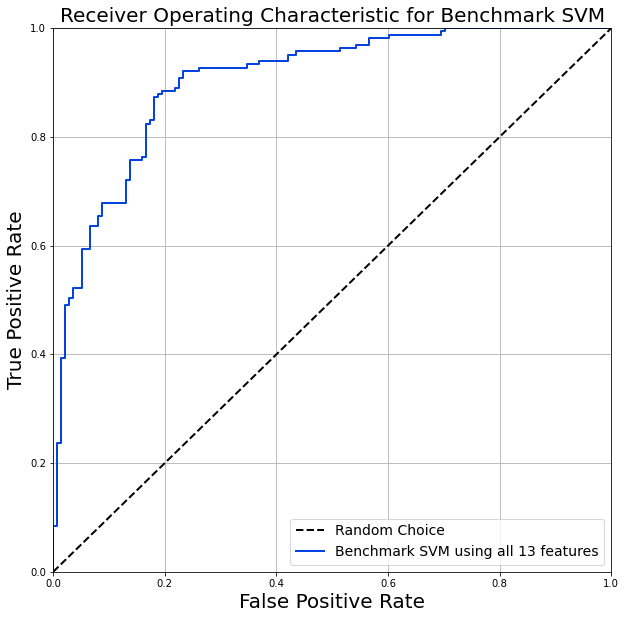

In [14]:
fpr_BM,tpr_BM = plot_roc_curve(test_labels_saved,BM_test_proba_preds,
                               'Benchmark SVM using all 13 features',
                               'Receiver Operating Characteristic for Benchmark SVM',
                              'xkcd:blue')

## Confusion Matrix and Precision & Recall for benchmark SVM:

For a binary classification problem, the confusion matrix is a 2x2 table showing both the correct and incorrect predictions made by the classifiers for both the positive and negative classes. It is useful to investigate the kind of mistakes the classifier is making - i.e. is it struggling mainly with the positive class or with the negative class? Or does it have an equal proportion of mistakes for both the positive and negative class.

The precision of a classifier measures the accuracy of a classifiers positive predictions, while the recall or true positive rate measures the ratio of positive samples that are correctly classified by the classifier.

The precision of a classifier's predictions is calculated as: $Precision = \frac{TP}{TP+FP}$

The recall of a classifiers predictions is calculated as: $Recall = \frac{TP}{TP+FN}$

where *TP = True positives*, *FP = False Positives*, and *FN = False Negatives*.

Again, I'm going to use a function for printing these values and generating the confusion matrix so that it can easily be reused later.

**Documentation for confusion_matrix:** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

**Documentation for precision_score:** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

**Documentation for recall_score:** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

In [15]:
def plot_conf_precision_recall(labels,preds,title):
    conf_mx = confusion_matrix(labels,preds) # Generates the confusion matrix using the classifiers predictions.
    precision = precision_score(labels,preds) # Calculates precision using equations shown above.
    recall = recall_score(labels,preds) # Calculates recall using equations shown above.
    print('Precision of classifier: {}'.format(precision))
    print('Recall of classifier: {}'.format(recall))
    
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8)) # Set the width and height of the heatmap.
    plt.title(title,fontsize=16) # Set major figure title.
    sns.heatmap(data=conf_mx, annot=True, ax=ax,
            cmap=sns.cubehelix_palette(start=1,hue=0, rot=0, dark=1, light=0.0,n_colors=2),
            fmt='g') # Set colour palette - I didn't want to use a gradient for discrete values, instead it plots white for large values (which should be the diagonal of the matrix for a decent classifier) and uses black for the incorrect predictions.
    ax.set_ylabel('True labels',fontsize=16) # Label y axis.
    ax.set_xlabel('Predicted labels',fontsize=16) # Label x axis.
    
    return precision,recall

Precision of classifier: 0.8232044198895028
Recall of classifier: 0.9030303030303031


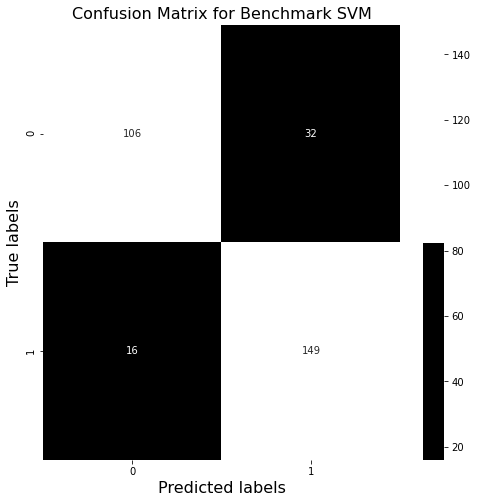

In [16]:
BM_precision, BM_recall = plot_conf_precision_recall(test_labels_saved,BM_test_preds_saved,"Confusion Matrix for Benchmark SVM")

## The benchmark SVM achieved the following performance:

Mean AUC across 10 test folds: **0.90**

Standard deviation of AUC across 10 test folds: **0.05**

Mean accuracy across 10 test folds: **0.84**

Standard deviation of accuracy across 10 test folds: **0.05**

Precision: **82%**

Recall: **90%**

# 6. Numerical Feature Univariate Analysis

**Numerical variables:** `age`, `trestbps`, `chol`, `thalach`, `oldpeak`, `ca`.

All but the `ca` feature are continuous numerical variables, while `ca` is a discrete numerical variable.

## Plot distributions of numerical features:

This is a quick and easy way of visualising the separation between the classes for each feature. This can give us an early indication of the numerical features that are most discriminative for the heart disease/healthy classes.

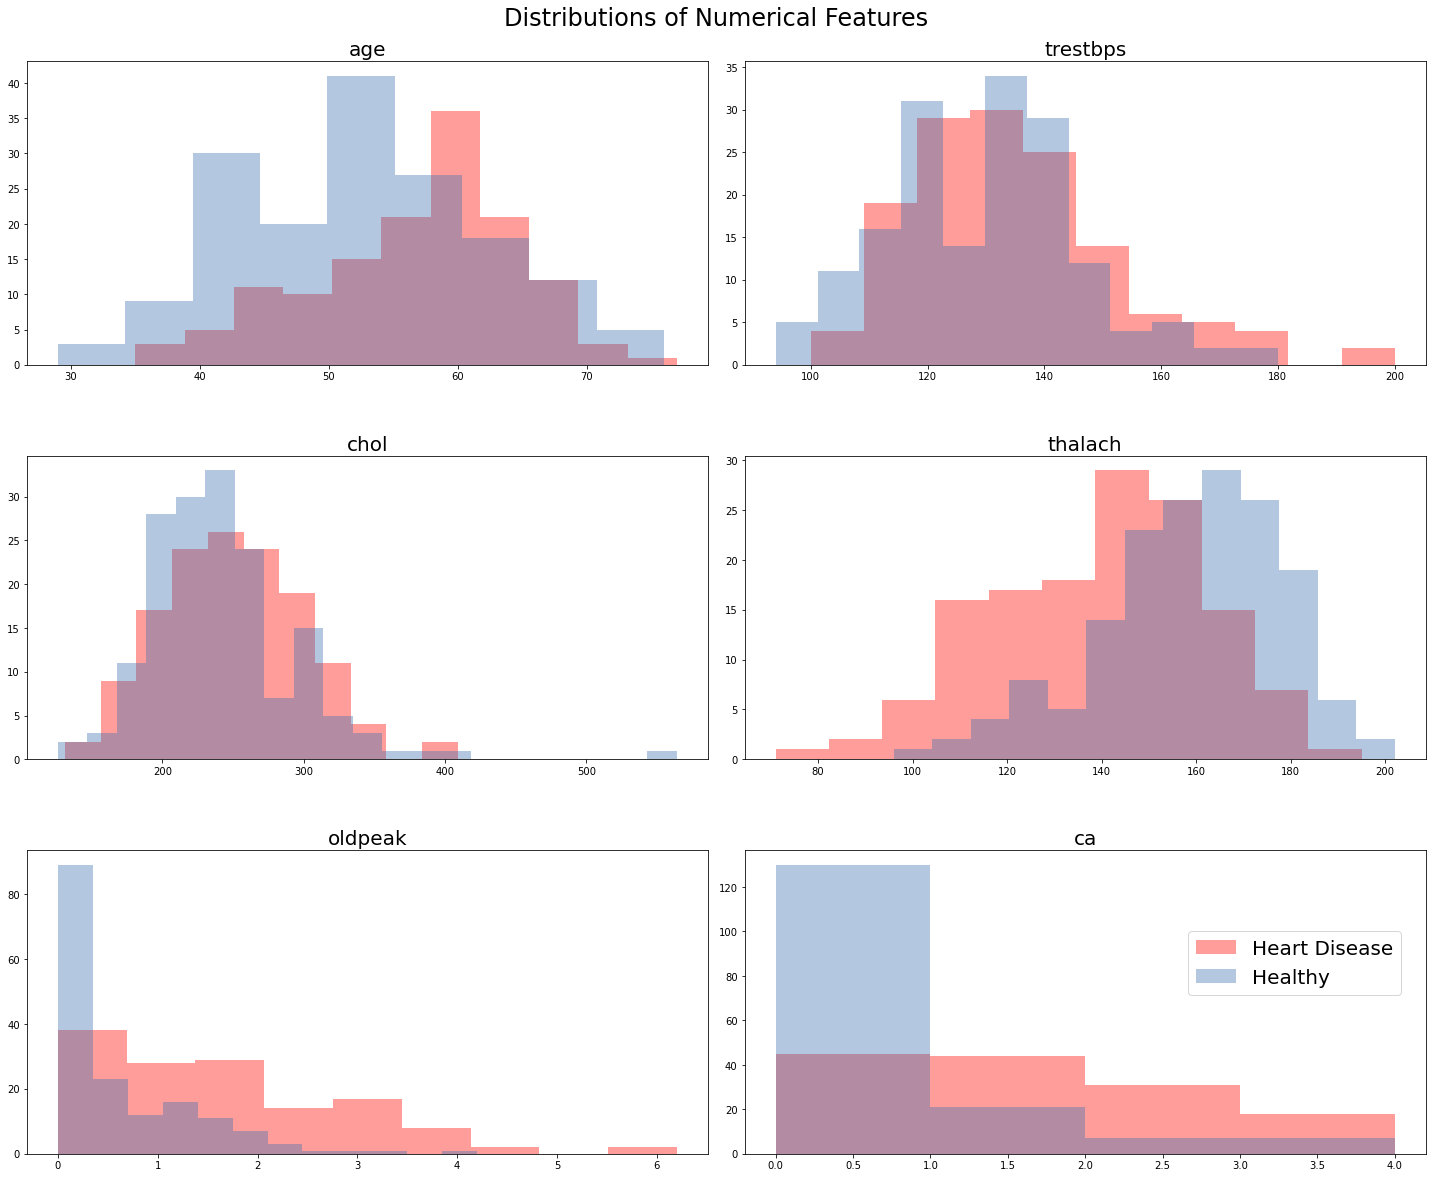

In [17]:
plot_height = 20 # Set figure height.
plot_width = 16 # Set figure width.
colours = ["#FF0B04", "#4374B3"] # Set colours for each class in the distribution.
sns.set_palette(sns.color_palette(colours)) # Create a seaborn palette of the 2 colours selected.
fig, ax = plt.subplots(3, 2, figsize=(plot_height, plot_width)) # Create figure with 3 rows and 2 columns of plots.

sns.distplot(raw_data.loc[raw_data.target==0].age, kde=False, ax=ax[0,0], axlabel = False) # Plot age distribution for heart disease class.
sns.distplot(raw_data.loc[raw_data.target==1].age, kde=False, ax=ax[0,0], axlabel = False) # Plot age distribution for healthy class.
ax[0,0].set_title("age", fontsize=20) # Set title of distribution to feature name.

sns.distplot(raw_data.loc[raw_data.target==0].trestbps, kde=False, ax=ax[0,1], axlabel = False) # Plot trestbps distribution for heart disease class.
sns.distplot(raw_data.loc[raw_data.target==1].trestbps, kde=False, ax=ax[0,1], axlabel = False) # Plot trestbps distribution for healthy class.
ax[0,1].set_title("trestbps", fontsize=20) # Set title of distribution to feature name.

sns.distplot(raw_data.loc[raw_data.target==0].chol, kde=False, ax=ax[1,0], axlabel = False) # Plot chol distribution for heart disease class.
sns.distplot(raw_data.loc[raw_data.target==1].chol, kde=False, ax=ax[1,0], axlabel = False) # Plot chol distribution for healthy class.
ax[1,0].set_title("chol", fontsize=20) # Set title of distribution to feature name.

sns.distplot(raw_data.loc[raw_data.target==0].thalach, kde=False, ax=ax[1,1], axlabel = False) # Plot thalach distribution for heart disease class.
sns.distplot(raw_data.loc[raw_data.target==1].thalach, kde=False, ax=ax[1,1], axlabel = False) # Plot thalach distribution for healthy class.
ax[1,1].set_title("thalach", fontsize=20) # Set title of distribution to feature name.

sns.distplot(raw_data.loc[raw_data.target==0].oldpeak, kde=False, ax=ax[2,0], axlabel = False) # Plot oldpeak distribution for heart disease class.
sns.distplot(raw_data.loc[raw_data.target==1].oldpeak, kde=False, ax=ax[2,0], axlabel = False) # Plot oldpeak distribution for healthy class.
ax[2,0].set_title("oldpeak", fontsize=20) # Set title of distribution to feature name.

sns.distplot(raw_data.loc[raw_data.target==0].ca, bins=[0, 1, 2, 3 , 4], kde=False, ax=ax[2,1], axlabel = False) # Plot ca distribution for heart disease class.
sns.distplot(raw_data.loc[raw_data.target==1].ca, bins=[0, 1, 2, 3 , 4], kde=False, ax=ax[2,1], axlabel = False) # Plot ca distribution for healthy class.
ax[2,1].set_title("ca", fontsize=20) # Set title of distribution to feature name.

fig.suptitle('Distributions of Numerical Features', fontsize=24,y=1.02) # Set major title of figure.
fig.tight_layout() # Remove whitespace in figure
plt.subplots_adjust(hspace=0.3) # Adjust major title vertical padding.

fig.legend(["Heart Disease", "Healthy"], loc='lower right', bbox_to_anchor=(0, 0.15, 0.98, 1.5), fontsize=20) # Create legend for all plots in the figure.

## Correlation matrix to check for redundant (highly correlated) features:

Using Pearson's correlation coefficient which measures the strength of the linear relationship between 2 features/variables to discover if any redundant (highly correlated) features exist in the numerical feature set. If redundant features are present, one of the correlated features can be dropped to reduce the dimensionality of the feature set. However, it doesn't assess non-linear relationships so this is a potential flaw in the methodology.

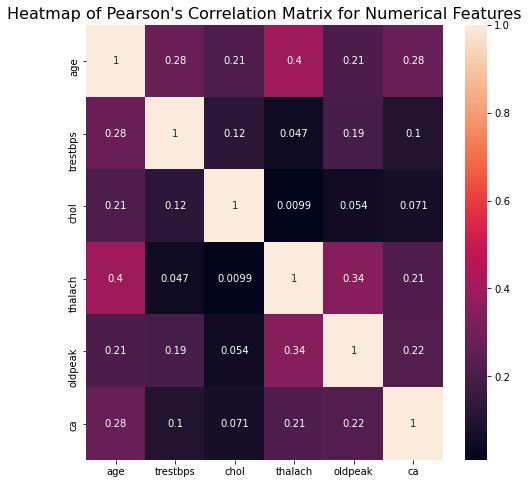

In [18]:
# .corr automatically creates the correlation matrix from a dataframe, by calculating the correlation of the
# dataframe column headings with the dataframe column headings. Pearson's correlation coefficient is used by default.
corr_matrix = num_feats.corr(method='pearson')

plt.figure(figsize=(8,8)) # Set the width and height of the heatmap.

plt.title("Heatmap of Pearson's Correlation Matrix for Numerical Features",fontsize=16) # Set major figure title.

sns.heatmap(data=np.abs(corr_matrix), annot=True) # Plotting absolute values of correlation coefficient 
                                                  # as we don't care if the features are positively or negatively correlated
                                                  # - the magnitude of the correlation coeff is the important part.

None of the numerical features are highly linearly correlated with each other. This can be verified with the scatter matrix of the numerical features, which visualises any relationships in the data. It produces a matrix of scatter plots of each feature plotted against all the other features in the dataframe. 

<ipython-input-19-79dd800cb4dd>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(num_feats,ax=ax) # Plot scatter matrix of numerical features using pandas function.


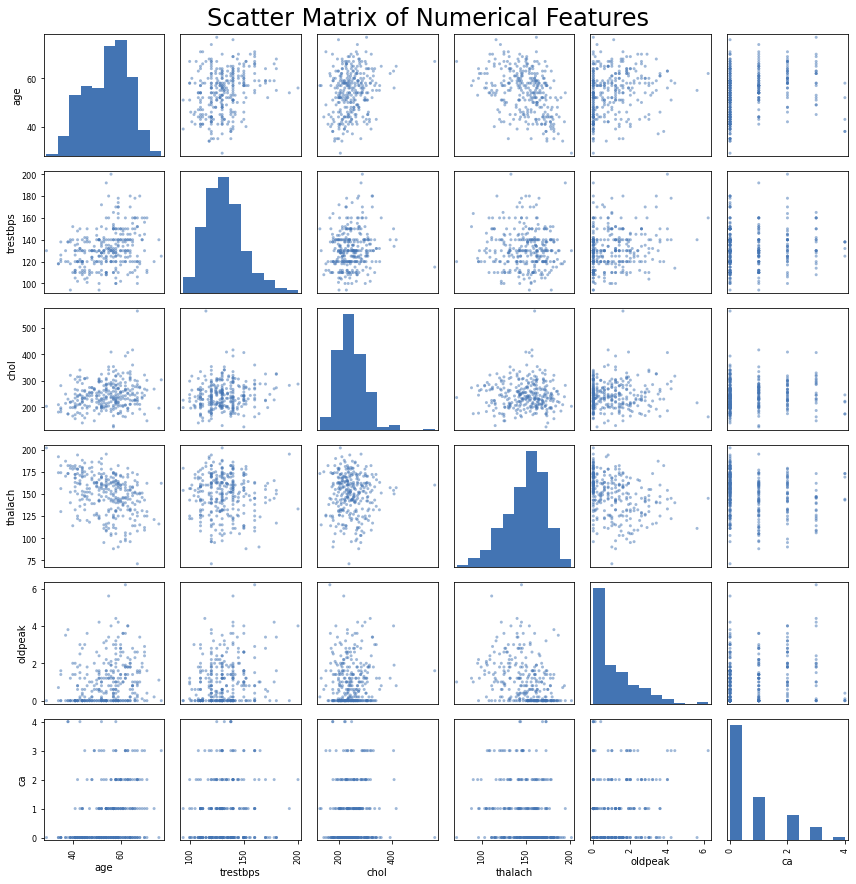

In [19]:
fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize=(12,12)) # Create matplotlib figure.
sns.set_palette(sns.color_palette(["#4374B3"])) # Set colour palette of scatter plot.
pd.plotting.scatter_matrix(num_feats,ax=ax) # Plot scatter matrix of numerical features using pandas function.
fig.suptitle('Scatter Matrix of Numerical Features', fontsize=24,y=1.02) # Set major title of figure.
fig.tight_layout() # Remove whitespace in figure.
plt.show()

## Plot ROCs and calculate AUCs to quantify the separability of numerical features:

Area Under the Receiver Operating Characteristic (AUC) is a direct measure of the separability between 2 classes for a given feature. 

An AUC of 1.0 for a particular feature means the classes are completely separable using this feature, with the values of this feature attributed to the positive class above the decision threshold on average. 

An AUC of 0.5 means the classes are totally overlapped for this feature - i.e. this feature does not offer any discrimination between the classes and is as good as random guessing. 

An AUC of 0.0 for a particular feature still means the classes are totally separable. However, an AUC of < 0.5 **for features** simply means that as the threshold to make predictions using this feature is increased, the values for the positive class (healthy in this case) are lower than the threshold on average. This can be verified by looking at the distribution of `ca` above - as the decision threshold moves from the left to the right of the x axis, the 'healthy' class (blue) would be below the threshold on average.

We can compare the results of the individual feature AUCs with the ANOVA score between the features and the labels to see if they correspond, and help us with univariate feature selection.

Area Under Curve of age = 0.6380983750548969
Area Under Curve of trestbps = 0.5702898550724638
Area Under Curve of chol = 0.5700702678963548
Area Under Curve of thalach = 0.7482652613087395
Area Under Curve of oldpeak = 0.7399209486166007
Area Under Curve of ca = 0.7365393061045236


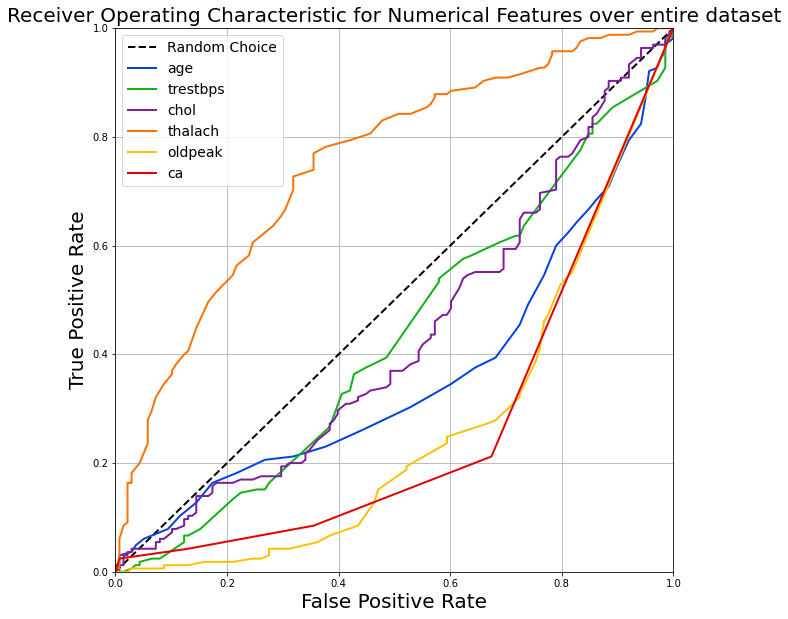

In [20]:
colour_palette = ['xkcd:blue','xkcd:green','xkcd:purple',
                  'xkcd:orange','xkcd:goldenrod','xkcd:red'] # Select colours to plot the feature ROCs.

plt.figure(figsize=(10,10)) # Create matplotlib figure.
plt.plot([0,1],[0,1],linewidth=2,label='Random Choice',
         color='black',linestyle='dashed') # Plot the diagonal corresponding to an AUC of 0.5.

for index,val in enumerate(num_feats.columns):
    # enumerate copies the values in num_feats.columns to val while simultaneously counting the iterations
    # with index.
    # Plot the TPR against the FPR for each feature i.e. the ROC:
    fpr, tpr, threshold = roc_curve(raw_data.target.values,raw_data[val].values)
    plt.plot(fpr,tpr,linewidth=2,label=val,color=colour_palette[index])
    
    AUC = roc_auc_score(raw_data.target.values,raw_data[val].values) # Compute AUC using sklearn's roc_auc_score function.
    if (AUC < 0.5):
        # An AUC of < 0.5 for a single feature simply means that as the threshold 
        # to make predictions is increased, the values for the positive class (healthy in this case)
        # are lower than the threshold on average. This can be verified by looking at the distribution
        # of 'ca' above - as the decision threshold moves from the left to the right of the x axis,
        # the 'healthy' class (blue) would be below the threshold on average.
        AUC = 1 - AUC
    print('Area Under Curve of {} = {}'.format(val,AUC))
    
plt.legend(fontsize=14) # Create legend.
plt.xlabel('False Positive Rate',fontsize=20) # Set x-axis label.
plt.ylabel('True Positive Rate',fontsize=20) # Set y-axis label.
plt.xlim([0,1]) # Limit x-axis to range [0,1].
plt.ylim([0,1]) # Limit y-axis to range [0,1].
plt.title('Receiver Operating Characteristic for Numerical Features over entire dataset',fontsize=20) # Set major title of ROC.
plt.grid() # Create gridlines.
plt.show()
    

## ANOVA Correlation:

Used to test the correlation between numerical data and a set of labels - in this case the numerical features and the target label. ANOVA correlation coefficient only measures the linear correlation. The results of the ANOVA correlation can be compared with the AUCs of the individual features, which gives us as much information as possible to make an informed decision in removing features.

**Documentation for f_classif:** https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif

In [21]:
F, p_val = f_classif(num_feats, labels) # Calculate ANOVA score between numerical features and target labels.
print('Feature:\tANOVA Score:')
for index,val in enumerate(num_feats.columns):
    print('{}      \t{:.2f}'.format(val,F[index])) # Print feature name and ANOVA score.

Feature:	ANOVA Score:
age      	16.12
trestbps      	6.46
chol      	2.20
thalach      	65.12
oldpeak      	68.55
ca      	54.56


The results from the ANOVA score and the AUC match up nicely, with `oldpeak`, `thalach`, `ca` and `age` as the 4 most relevant features. `oldpeak`, `thalach` and `ca` are the numerical features that will be used in the univariate feature selection model, as these have a much higher AUC and ANOVA score than the remaining numerical features.

In [22]:
num_feats_univar_sel = num_feats.loc[:,['oldpeak','thalach','ca']] # Isolate the most relevant numerical features.
num_feats_univar_sel # Inspect new dataframe.

,oldpeak,thalach,ca
0,2.3,150,0
1,3.5,187,0
2,1.4,172,0
3,0.8,178,0
4,0.6,163,0
...,...,...,...
298,0.2,123,0
299,1.2,132,0
300,3.4,141,2
301,1.2,115,1


# 7. Categorical Features Univariate Analysis:

## Mutual Information

Mutual information is used to determine the correlation between discrete categorical variables, in this case between the categorical features and the target. First I'll use it to create a 'correlation' matrix, to see if any of the categorical features are highly correlated with each other (i.e. redundant), and then use it to calculate the 'correlation' between the categorical features and the labels.

**Documentation for mutual_info_classif:** https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

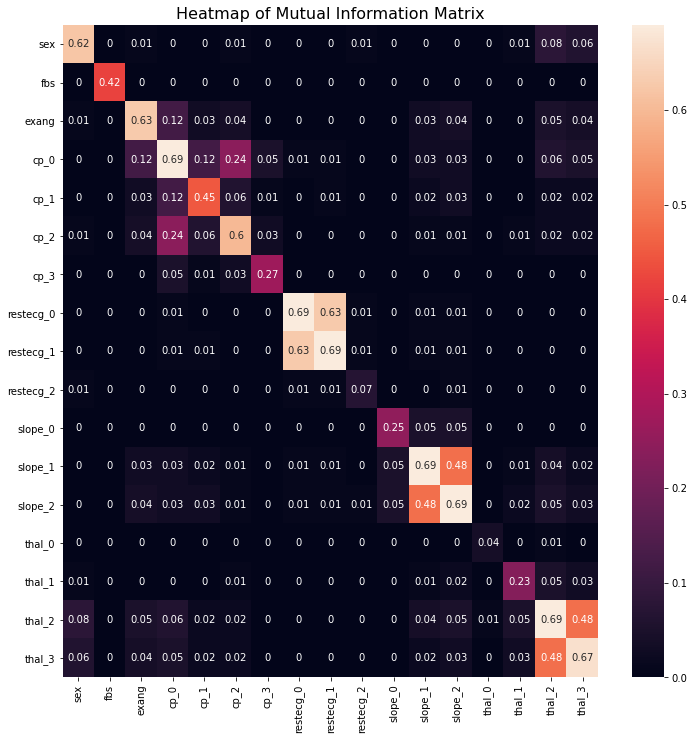

In [23]:
MI_arr = np.zeros((cat_feats.shape[1],cat_feats.shape[1])) # Initialise a numpy array to store the mutual information scores between each feature.

for index,val in enumerate(cat_feats.columns):
    # Iterate through the encoded categorical features and calculate the mutual information between
    # all the features and that individual feature, to identify any redundant features.
    # discrete_features=True tells sklearn that categorical/non-continuous features are being tested,
    # as continuous numbers need to be binned.
    MI_arr[index,:] = mutual_info_classif(cat_feats, cat_feats.loc[:,val],discrete_features=True)
                                                    
mutual_info_df = pd.DataFrame(MI_arr,columns=cat_feats.columns,
                              index=cat_feats.columns) # Convert numpy array into a pandas dataframe with corresponding feature labels as header and index.

plt.figure(figsize=(12,12)) # Set the width and height of the heatmap.

plt.title("Heatmap of Mutual Information Matrix",fontsize=16) # Add title.

sns.heatmap(data=np.round(mutual_info_df,2), annot=True) # Plot heatmap of mutual information scores.

In general, there is no highly redundant features that are obvious from the heatmap. Some of the one hot encoded features are correlated with each other, which is to be expected as they're derived from the same feature (e.g. `thal_2` and `thal_3` have a high mutual information because they're both derived from `thal`).

Next we calculate the mutual information between the categorical features and the labels for univariate feature selection, removing any features with a mutual information of less than 0.05. This threshold was picked as it gave a total number of features = 10 between the numerical and categorical features.

In [24]:
score = mutual_info_classif(cat_feats, labels,discrete_features=True) # Calculate mutual information between categorical features and target labels.
cat_feats_univar_sel = [] # Initialise list to store the features with a mutual info >= 0.05.

print('Feature:\tMutual Info:')

for index,val in enumerate(cat_feats.columns):
    # Iterate through the encoded categorical features and print the mutual information
    # score between that feature and the target label:
    print('{}      \t{:.2f}'.format(val,score[index]))
    
    if np.round(score[index],2) >= 0.05:
        # If the mutual information is greater than 0.05, we retain the feature.
        cat_feats_univar_sel.append(val)
        
print('\nSelected features are:',cat_feats_univar_sel) # Print retained features.

Feature:	Mutual Info:
sex      	0.04
fbs      	0.00
exang      	0.10
cp_0      	0.14
cp_1      	0.03
cp_2      	0.05
cp_3      	0.00
restecg_0      	0.01
restecg_1      	0.02
restecg_2      	0.00
slope_0      	0.00
slope_1      	0.07
slope_2      	0.08
thal_0      	0.00
thal_1      	0.01
thal_2      	0.15
thal_3      	0.12

Selected features are: ['exang', 'cp_0', 'cp_2', 'slope_1', 'slope_2', 'thal_2', 'thal_3']


## Combining the numerical and categorical features selected during the univariate feature selection process:

As we're using a Gaussian kernel SVM  with the features selected using univariate feature selection, the numerical features must be scaled or the largest features will dominate the SVM decision boundary.

In [25]:
std_scaler_univar = StandardScaler() # Initialise standard scaler transformer to standardise the selected numerical features.
num_feats_univar_scaled = std_scaler_univar.fit_transform(num_feats_univar_sel) # Transform the univar selected numerical feats.
num_feats_univar_scaled = pd.DataFrame(num_feats_univar_scaled,columns = num_feats_univar_sel.columns) # Convert numerical feats back to a dataframe.
num_feats_univar_scaled # Inspect dataframe.

,oldpeak,thalach,ca
0,1.087338,0.015443,-0.714429
1,2.122573,1.633471,-0.714429
2,0.310912,0.977514,-0.714429
3,-0.206705,1.239897,-0.714429
4,-0.379244,0.583939,-0.714429
...,...,...,...
298,-0.724323,-1.165281,-0.714429
299,0.138373,-0.771706,-0.714429
300,2.036303,-0.378132,1.244593
301,0.138373,-1.515125,0.265082


In [26]:
univar_feats_sel = num_feats_univar_scaled.join(cat_feats.loc[:,cat_feats_univar_sel])  # Join the numerical and categorical selected features dataframe. Identical functionality to .concat() when both dataframes have the same index.
univar_feats_sel # Inspect the resulting dataframe.

,oldpeak,thalach,ca,exang,cp_0,cp_2,slope_1,slope_2,thal_2,thal_3
0,1.087338,0.015443,-0.714429,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.122573,1.633471,-0.714429,0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.310912,0.977514,-0.714429,0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.206705,1.239897,-0.714429,0,0.0,0.0,0.0,1.0,1.0,0.0
4,-0.379244,0.583939,-0.714429,1,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
298,-0.724323,-1.165281,-0.714429,1,1.0,0.0,1.0,0.0,0.0,1.0
299,0.138373,-0.771706,-0.714429,0,0.0,0.0,1.0,0.0,0.0,1.0
300,2.036303,-0.378132,1.244593,0,1.0,0.0,1.0,0.0,0.0,1.0
301,0.138373,-1.515125,0.265082,1,1.0,0.0,1.0,0.0,0.0,1.0


The number of features has been reduced from 23 (after One Hot Encoding) to just 10.

# 8. Fitting a Gaussian kernel SVM to features selected via univariate feature selection:

The same 'Leave 30 Subjects Out'/10-fold performance evaluation is used to assess the performance of the classifier using the features selected via filter methods. A Gaussian kernel SVM is evaluated with the selected features.

In [27]:
%%time
n_test_folds = 10 # Number of test folds to create.
n_cv_folds = 5 # Number of folds in the internal hyperparameter cross validation.

param_grid = {'gamma':[0.001,0.01,0.1,1,10,100],
              'C':[0.001,0.01,0.1,1,10,100]} # Define the values of the hyperparameters C and gamma to search over.
scoring = {'AUC': 'roc_auc',
        'Accuracy': make_scorer(accuracy_score)} # Define the multi-metric scoring to use in the gridsearch (AUC and accuracy).

test_CV = StratifiedKFold(n_splits = n_test_folds, shuffle=True, random_state=0) # Initialise the Stratified/Shuffle/Split for the 10 folds.
test_counter = 0 # Tracks the current test fold number.

best_CV_hyperparams = [] # Stores the optimal set of hyperparameters based on the internal cross validation.
AUCs = [] # Stores AUCs from each of the 10 test folds.
accuracy_scores = [] # Stores accuracy scores from each of the 10 test folds.

# The following lists save results from the 10 folds so that metrics like the ROC can be computed:
test_labels_saved = [] # Saves the test labels in the order in which they appeared in test folds.
UVAR_test_proba_preds = []  # Saves the univariate SVM probability predictions in the order in which they were completed in test folds.
UVAR_test_preds_saved = [] # Saves the univariate SVM predictions in the order in which they were completed in test folds.


for train_idx,test_idx in test_CV.split(univar_feats_sel,labels):
    # ================= Model Evaluation Loop =================
    # In this loop, n_test_folds - 1 folds are used as training data, while the remaining
    # fold is used as test data. No data from subjects in the training data appear in the test data
    # and vice versa. A stratified shuffle split is done, such that the class distribution in the test set is preserved
    # when possible.
    # The RBF kernel SVM is trained using the best parameters from the internal CV,
    # and the AUC and accuracy is computed for each test subject in the test fold.
    # =========================================================

    # Extract the training and test data for this iteration's test fold:
    training_set, test_set = univar_feats_sel.iloc[train_idx,:], univar_feats_sel.iloc[test_idx,:]
    training_labels, test_labels = labels.values[train_idx], labels.values[test_idx]
    
    svm_clf = SVC(kernel='rbf', probability=True) # Initialise SVM estimator. 
                                    # probability=True allows the SVM to output a probability of a given class which can
                                    # be used to compute the AUC.

    # Gridsearch uses 5 fold cross validation for the SVM and hyperparameter values defined above. Both the accuracy and AUC
    # are used as the scoring metric. The model with the best mean AUC across the 5 folds is selected and then retrained
    # over all 5 CV folds subjects. n_jobs=-1 uses all processors available to run the gridsearch in parallel, speeding it up.
    grid_search = GridSearchCV(svm_clf, param_grid, cv=n_cv_folds, scoring=scoring,
                           verbose=0, refit='AUC', n_jobs=-1)
    grid_search.fit(training_set.values,training_labels) # Run the gridsearch on the training data for this iteration.
    
    print('\n===== {} of {} evaluations ====='.format(test_counter+1,n_test_folds))
    print('Best hyperparameters from 5-fold CV: {}'.format(grid_search.best_params_)) # Print the best set of hyperparameters.
    print('Best validation AUC achieved: {}'.format(grid_search.best_score_)) # Print the best mean AUC across 5 CV folds.
    
    best_C, best_gamma = grid_search.best_params_['C'], grid_search.best_params_['gamma'] # Extract best C and gamma hyperparams from the CV.
    best_CV_hyperparams.append((best_C,best_gamma)) # Stores the best performing pair of hyperparameter values from CV.
    
    best_SVM = grid_search.best_estimator_ # Intialise the best performing SVM from the CV. 
                                           # refit='AUC' means the SVM with the best AUC was refit to all training data used in the gridsearch.
    
    test_proba = best_SVM.predict_proba(test_set)[:,1] # Return probability of class 1 (healthy) for test subjects.
    test_preds = best_SVM.predict(test_set) # Return class predictions (used for accuracy).
    
    test_labels_saved = np.append(test_labels_saved, test_labels) # Save labels from this test fold.
    UVAR_test_proba_preds = np.append(UVAR_test_proba_preds, test_proba) # Save probability predictions from this test fold.
    UVAR_test_preds_saved = np.append(UVAR_test_preds_saved, test_preds) # Save class predictions from this test fold.
    
    accuracy = accuracy_score(test_labels,test_preds) # Return accuracy of SVM on this test fold.
    AUC = roc_auc_score(test_labels,test_proba) # Return AUC of SVM on this test fold.
    accuracy_scores.append(accuracy) # Save the accuracy for this test fold.
    AUCs.append(AUC) # Save the AUC for this test fold.
    
    print('AUC across test set: {}'.format(AUC)) # Print AUC for this test fold.
    print('Accuracy across test set: {}'.format(accuracy)) # Print accuracy for this test fold.
    
    test_counter += 1 # Increment variable that counts the test fold iterations.

# Counts the tuples of (C,gamma) in best_CV_hyperparams and returns the tuple with the highest count,
# i.e. it returns the (C,gamma) pair that were selected most frequently during the internal
# 5 fold CV:
mode_C,mode_gamma = max(set(best_CV_hyperparams), key=best_CV_hyperparams.count) 

print('\n===== Final Performance Across All Subjects =====')
print('List of features retained via univariate feature selection: {}'.format(list(univar_feats_sel.columns)))
print('\nMean AUC across all test folds: {:.2f}'.format(np.mean(AUCs)))
print('Standard Deviation of AUC across all test folds: {:.2f}'.format(np.std(AUCs)))
print('Median of AUC across all test folds: {:.2f}'.format(np.median(AUCs)))
print('Interquartile Range of AUC across all test folds: {:.2f}'.format(np.subtract(*np.percentile(AUCs, [75, 25]))))
print('\nMean accuracy across all test folds: {:.2f}'.format(np.mean(accuracy_scores)))
print('Standard Deviation of accuracy across all test folds: {:.2f}'.format(np.std(accuracy_scores)))
print('Median of accuracy across all test folds: {:.2f}'.format(np.median(accuracy_scores)))
print('Interquartile Range of accuracy across all test folds: {:.2f}'.format(np.subtract(*np.percentile(accuracy_scores, [75, 25]))))
print('\nThe most common hyperparameters selected were: C = {} gamma = {} '.format(mode_C,mode_gamma))


===== 1 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'C': 1, 'gamma': 0.1}
Best validation AUC achieved: 0.9200137931034483
AUC across test set: 0.8991596638655461
Accuracy across test set: 0.8064516129032258

===== 2 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'C': 1, 'gamma': 0.1}
Best validation AUC achieved: 0.9170727969348658
AUC across test set: 0.8949579831932774
Accuracy across test set: 0.9354838709677419

===== 3 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'C': 10, 'gamma': 0.01}
Best validation AUC achieved: 0.9225915708812261
AUC across test set: 0.823529411764706
Accuracy across test set: 0.7741935483870968

===== 4 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'C': 1, 'gamma': 0.1}
Best validation AUC achieved: 0.9203402298850575
AUC across test set: 0.8914027149321267
Accuracy across test set: 0.8666666666666667

===== 5 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'C': 1, 'gamma': 0.1

The SVM achieved a marginally better performance than the benchmark SVM tested previously, with the mean AUC improving to 0.91 while the standard deviation in the AUC decreased to 0.04. The accuracy of the SVM did not change. The most common hyperparameters selected were C = 1 and gamma = 0.1, which is quite different to the most common hyperparameters selected for the benchmark model (C = 10 and gamma = 0.001).

This indicates that the SVM is actually quite robust to useless or noisey features, with the benchmark SVM achieving only a marginally lower result. However, the number of features was reduced from 23 to 10, which sped up the 10-fold evaluation (6.78 s vs 11.1 s for the benchmark). This difference isn't noticeable for such a small dataset, but for much larget datasets with thousands of training instances and possibly hundreds of features, it could make a huge difference.

## Receiver Operating Characteristic for SVM with Univariate Feature Selection:

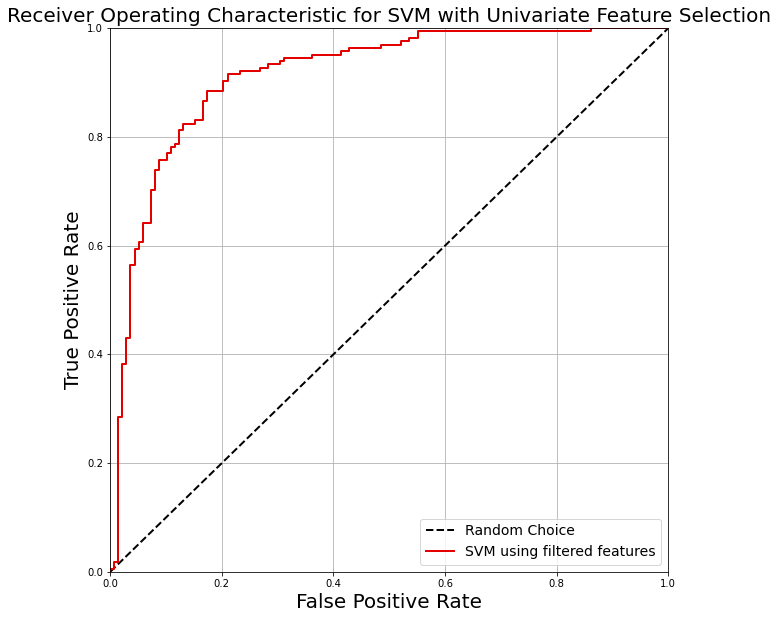

In [28]:
fpr_univar,tpr_univar = plot_roc_curve(test_labels_saved,UVAR_test_proba_preds,
                               'SVM using filtered features',
                               'Receiver Operating Characteristic for SVM with Univariate Feature Selection',
                              'xkcd:red')

## Confusion Matrix and Precision & Recall for SVM with Univariate Feature Selection:

Precision of classifier: 0.8333333333333334
Recall of classifier: 0.9090909090909091


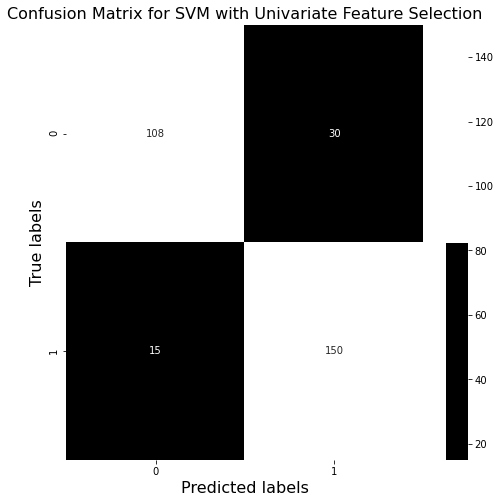

In [29]:
univar_precision, univar_recall = plot_conf_precision_recall(test_labels_saved,UVAR_test_preds_saved,
                                                             "Confusion Matrix for SVM with Univariate Feature Selection")

## The SVM with Univariate Feature Selection achieved the following performance:

Mean AUC across 10 test folds: **0.91**

Standard deviation of AUC across 10 test folds: **0.04**

Mean accuracy across 10 test folds: **0.85**

Standard deviation of accuracy across 10 test folds: **0.05**

Precision: **83%**

Recall: **91%**

# 9. Embedded Feature Selection

Random Forests is a machine learning model that can automatically perform feature selection - i.e. it intrinsically performs feature selection during model training. A random forest is constructed from many parallel decision trees trained on subsets of the data and subsets of the features. The decision tree is constructed by selecting the feature from the sub-sampled features which minimises the impurity at the output node - the output is pure if all training instances it applies to belongs to the same class. Through this, it automatically selects the best performing features to construct the decision boundary.

The 'Leave 30 Subjects Out'/10-fold evaluation is again used to evaluate the model, but with a few tweaks. The Random Forest obviously has different hyperparameters to the Gaussian kernel SVM. `n_estimators` corresponds to the number of trees in the forest, `max_depth` corresponds to the maximum number of nodes in each tree, and `max_features` specifies the maximum number of features to sample from the full feature set when constructing each tree - 'sqrt' specifies the number of features to be sampled as the square root of the total number of features, and 0.5 specifies half the features to be sampled.

At each iteration of the 10-fold evaluation, the 'feature importances' of each feature is evaluated - the feature importance for each feature computes the normalized total reduction in Gini impurity produced by that feature. The feature importances are stored in `feat_importance_df`. At the end of the evaluation, the mean feature importance across the 10 folds is computed. The 10 most important features are then printed. This allows for a comparison to be made with those features selected via univariate feature selection methods and those selected by the Random Forest model.

Note that the 10-fold evaluation is carried out on the full feature set i.e. no prior feature selection is carried out.

In [30]:
%%time
n_test_folds = 10 # Number of test folds to create.
n_cv_folds = 5 # Number of folds in the internal hyperparameter cross validation.

param_grid = {'n_estimators':[10,20,50,100,200,500],
              'max_depth':[2,3,4,5,10], 'max_features':['sqrt',0.5]} # Define the values of the RF hyperparameters to search over.

scoring = {'AUC': 'roc_auc',
        'Accuracy': make_scorer(accuracy_score)} # Define the multi-metric scoring to use in the gridsearch (AUC and accuracy).

test_CV = StratifiedKFold(n_splits = n_test_folds, shuffle=True, random_state=0) # Initialise the Stratified/Shuffle/Split for the 10 folds.
test_counter = 0 # Tracks the current test fold number.

best_CV_hyperparams = [] # Stores the optimal set of hyperparameters based on the internal cross validation.
AUCs = [] # Stores AUCs from each of the 10 test folds.
accuracy_scores = [] # Stores accuracy scores from each of the 10 test folds.
feat_importance_df = pd.DataFrame(np.zeros((n_test_folds,len(feats_prepared.columns))),
                                  columns = feats_prepared.columns) # Dataframe to evaluate the feature importances for each of the 10 test folds.

# The following lists save results from the 10 folds so that metrics like the ROC can be computed:
test_labels_saved = [] # Saves the test labels in the order in which they appeared in test folds.
RF_test_proba_preds = []  # Saves the random forest's probability predictions in the order in which they were completed in test folds.
RF_test_preds_saved = [] # Saves the random forest's predictions in the order in which they were completed in test folds.

for train_idx,test_idx in test_CV.split(feats_prepared,labels):
    # ================= Model Evaluation Loop =================
    # In this loop, n_test_folds - 1 folds are used as training data, while the remaining
    # fold is used as test data. No data from subjects in the training data appear in the test data
    # and vice versa. A stratified shuffle split is done, such that the class distribution in the test set is preserved
    # when possible.
    # The Random Forest is trained using the best parameters from the internal CV,
    # and the AUC and accuracy is computed for each test subject in the test fold.
    # =========================================================

    # Extract the training and test data for this iteration's test fold:
    training_set, test_set = feats_prepared.iloc[train_idx,:], feats_prepared.iloc[test_idx,:]
    training_labels, test_labels = labels.values[train_idx], labels.values[test_idx]
    
    RF_clf = RandomForestClassifier(n_jobs=-1, random_state=0) # Initialise RF estimator. random_state sets the seed of the RNG when sampling data.
                                                               # n_jobs=-1 allows all available processors to be used to train the model, speeding it up.

    # Gridsearch uses 5 fold cross validation for the RF and hyperparameter values defined above. Both the accuracy and AUC
    # are used as the scoring metric. The model with the best mean AUC across the 5 folds is selected and then retrained
    # over all 5 CV folds subjects. n_jobs=-1 uses all processors available to run the gridsearch in parallel, speeding it up.
    grid_search = GridSearchCV(RF_clf, param_grid, cv=5, scoring=scoring,
                           verbose=0, refit='AUC', n_jobs=-1)
    grid_search.fit(training_set.values,training_labels) # Run the gridsearch on the training data for this iteration.
    
    print('\n===== {} of {} evaluations ====='.format(test_counter+1,n_test_folds))
    print('Best hyperparameters from 5-fold CV: {}'.format(grid_search.best_params_)) # Print the best set of hyperparameters.
    print('Best validation AUC achieved: {}'.format(grid_search.best_score_)) # Print the best mean AUC across 5 CV folds.
    
    # Extract best RF hyperparams from the CV:
    best_nestimators = grid_search.best_params_['n_estimators']
    best_depth = grid_search.best_params_['max_depth']
    best_feats = grid_search.best_params_['max_features'] 
    
    best_CV_hyperparams.append((best_nestimators, best_depth, best_feats)) # Stores the best performing hyperparameter values from CV.
    
    best_RF = grid_search.best_estimator_ # Intialise the best performing RF from the CV. 
                                           # refit='AUC' means the RF with the best AUC was refit to all training data used in the gridsearch.
    
    # Store the feature importances for this iteration of the performance evaluation:
    for index,val in enumerate(best_RF.feature_importances_):
        # Iterate through each feature's importance as determined by the RF model, and stores it in the corresponding
        # cell of the dataframe for this test fold.
        feat_importance_df.iloc[test_counter,index] = val
    
    test_proba = best_RF.predict_proba(test_set)[:,1] # Return probability of class 1 (healthy) for test subjects.
    test_preds = best_RF.predict(test_set) # Return class predictions (used for accuracy).
    
    test_labels_saved = np.append(test_labels_saved, test_labels) # Save labels from this test fold.
    RF_test_proba_preds = np.append(RF_test_proba_preds, test_proba) # Save probability predictions from this test fold.
    RF_test_preds_saved = np.append(RF_test_preds_saved, test_preds) # Save class predictions from this test fold.
    
    accuracy = accuracy_score(test_labels,test_preds) # Return accuracy of RF on this test fold.
    AUC = roc_auc_score(test_labels,test_proba) # Return AUC of RF on this test fold.
    accuracy_scores.append(accuracy) # Save the accuracy for this test fold.
    AUCs.append(AUC) # Save the AUC for this test fold.
    
    print('AUC across test set: {}'.format(AUC)) # Print AUC for this test fold.
    print('Accuracy across test set: {}'.format(accuracy)) # Print accuracy for this test fold.
    
    test_counter += 1 # Increment variable that counts the test fold iterations.

# Counts the tuples of RF hyperparameters in best_CV_hyperparams and returns the tuple with the highest count,
# i.e. it returns the (n_estimators,max_depth,max_features) hyperparameters that were selected most frequently during the internal
# 5 fold CV:
mode_est,mode_depth, mode_feats = max(set(best_CV_hyperparams), key=best_CV_hyperparams.count)
mean_feat_importances = np.mean(feat_importance_df.values,axis=0) # Computes the mean of the feature importances over the 10 folds.

print('\n===== Final Performance Across All Subjects =====')
print('Mean AUC across all test folds: {:.2f}'.format(np.mean(AUCs)))
print('Standard Deviation of AUC across all test folds: {:.2f}'.format(np.std(AUCs)))
print('Median of AUC across all test folds: {:.2f}'.format(np.median(AUCs)))
print('Interquartile Range of AUC across all test folds: {:.2f}'.format(np.subtract(*np.percentile(AUCs, [75, 25]))))
print('\nMean accuracy across all test folds: {:.2f}'.format(np.mean(accuracy_scores)))
print('Standard Deviation of accuracy across all test folds: {:.2f}'.format(np.std(accuracy_scores)))
print('Median of accuracy across all test folds: {:.2f}'.format(np.median(accuracy_scores)))
print('Interquartile Range of accuracy across all test folds: {:.2f}'.format(np.subtract(*np.percentile(accuracy_scores, [75, 25]))))
print('\nThe most common hyperparameters selected were: n_estimators = {} max_depth = {} max_features = {}'.format(mode_est,mode_depth,mode_feats))
print('\nThe 10 features with the highest mean importance across the 10 test folds were:')
for index in np.argsort(mean_feat_importances)[::-1][:10]:
    # Prints the 10 features with the highest mean importance across the 10 test folds.
    # argsort returns a list containing the sorted indexes of the list/array that was passed 
    # (sorting is done from lowest to highest so [::-1] slice must be used to reverse the order of
    # the list).
    print('{}      \t{:.2f}'.format(feats_prepared.columns[index],mean_feat_importances[index]))


===== 1 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 200}
Best validation AUC achieved: 0.9185812260536398
AUC across test set: 0.8697478991596639
Accuracy across test set: 0.7419354838709677

===== 2 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 20}
Best validation AUC achieved: 0.9193421455938697
AUC across test set: 0.9159663865546218
Accuracy across test set: 0.9354838709677419

===== 3 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100}
Best validation AUC achieved: 0.9207662835249042
AUC across test set: 0.8235294117647058
Accuracy across test set: 0.7096774193548387

===== 4 of 10 evaluations =====
Best hyperparameters from 5-fold CV: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10}
Best validation AUC achieved: 0.9246022988505749
AUC across test set: 0.

## Receiver Operating Characteristic for Random Forest:

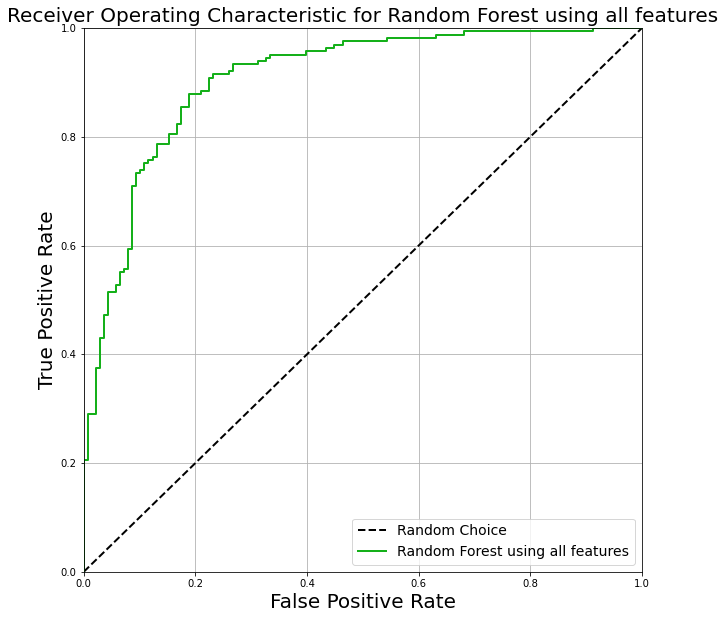

In [31]:
fpr_RF,tpr_RF = plot_roc_curve(test_labels_saved,RF_test_proba_preds,
                               'Random Forest using all features',
                               'Receiver Operating Characteristic for Random Forest using all features',
                              'xkcd:green')

## Confusion Matrix and Precision & Recall for Random Forest:

Precision of classifier: 0.8295454545454546
Recall of classifier: 0.8848484848484849


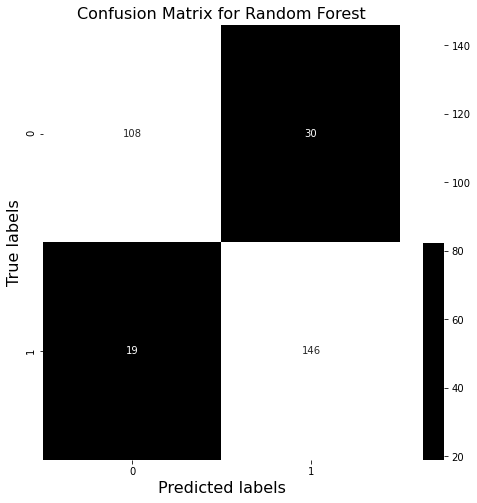

In [32]:
RF_precision, RF_recall = plot_conf_precision_recall(test_labels_saved,RF_test_preds_saved,
                                                             "Confusion Matrix for Random Forest")

## The Random Forest achieved the following performance:

Mean AUC across 10 test folds: **0.91**

Standard deviation of AUC across 10 test folds: **0.04**

Mean accuracy across 10 test folds: **0.84**

Standard deviation of accuracy across 10 test folds: **0.07**

Precision: **83%**

Recall: **88%**

# 10. Wrapper-based Feature Selection

Wrapper feature selection methods use a machine learning model to evaluate the importance of the features using either some cost function or the weights assigned by the model to each feature. Recursive Feature Elimination works by iteratively removing  the features with the lowest weights assigned until only the desired number of features remains. That is, it trains the model using all features on the training set. It assesses the weights assigned by the model to all features and removes the feature with the lowest weight. The model is then retrained with N-1 features and this process is repeated until the desired number of features remain. The importance of this wrapper method is that it does not assess the individual importance of each feature: instead, it considers the group of features as a whole that maximises the performance of the classifier on the training set. This is a multivariate approach that contrasts with the earlier univariate feature selection method.

A linear SVM with the default value for the regularisation hyperparameter `C` is used for RFE because the weights of the Gaussian kernel SVM can't be directly computed (due to the kernel trick).

The 'Leave 30 Subjects Out' or 10-fold Performance evaluation was adapted for this wrapper method: The internal gridsearch was removed and for each of the 10 test folds, the retained features for this iteration are counted. Once all 10 test folds have been evaluated, the 10 features selected most frequently across the 10 folds are printed to the notebook, along with summary statistics of the model performance over the 10 folds, as was the case with earlier models.

**Documentation for RFE:** https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [33]:
%%time
n_test_folds = 10 # Number of folds to create in the outer loop - i.e. number of independent test sets to create.

test_CV = StratifiedKFold(n_splits = n_test_folds, shuffle=True, random_state=0) # Initialise the Stratified/Shuffle/Split for the 10 folds.
test_counter = 0 # Tracks the current test fold number.

AUCs = [] # Stores AUCs from each of the 10 test folds.
accuracy_scores = [] # Stores accuracy scores from each of the 10 test folds.

feat_counts = np.zeros((len(feats_prepared.columns))) # Tracks how many times each feature was selected across 10 test folds.

# The following lists save results from the 10 folds so that metrics like the ROC can be computed:
test_labels_saved = [] # Saves the test labels in the order in which they appeared in test folds.
RFE_test_proba_preds = []  # Saves the probability predictions in the order in which they were completed in test folds.
RFE_test_preds_saved = [] # Saves the predictions in the order in which they were completed in test folds.


for train_idx,test_idx in test_CV.split(feats_prepared,labels):
    # ================= Model Evaluation Loop =================
    # In this loop, n_test_folds - 1 folds are used as training data, while the remaining
    # fold is used as test data. No data from subjects in the training data appear in the test data
    # and vice versa. A stratified shuffle split is done, such that the class distribution in the test set is preserved
    # when possible.
    # The linear SVM is trained using the best features from recursive feature elimination,
    # and the AUC and accuracy is computed for each test subject in the test fold.
    # =========================================================

    # Extract the training and test data for this iteration's test fold:
    training_set, test_set = feats_prepared.iloc[train_idx,:], feats_prepared.iloc[test_idx,:]
    training_labels, test_labels = labels.values[train_idx], labels.values[test_idx]
    
    svm_clf = SVC(kernel='linear', C=1.0, probability=True) # Initialise SVM estimator. 
                                    # probability=True allows the SVM to output a probability of a given class which can
                                    # be used to compute the AUC. Using a linear kernel.

    rfe_svm = RFE(estimator=svm_clf, n_features_to_select=10, step=1) # Initialise the RFE transformer using the linear SVM, retaining 10 features and only removing 1 feature at each iteration.
    rfe_svm.fit(training_set.values,training_labels) # Run RFE on the training data for this iteration.
    
    print('\n===== {} of {} evaluations ====='.format(test_counter+1,n_test_folds))
    # Print the 10 features selected by RFE at this iteration (.ranking_ is a mask which assigns 1 to all the selected features).
    # argsort returns the indexes of the sorted elements in the list (lowest to highest). As the .ranking_ attribute
    # assigns a rank of 1 to the most important features, we don't need to reverse the list as we did earlier.
    # We can simply slice the first 10 elements to obtain the top 10 features.
    print('10 features selected by RFE: {}'.format(list(feats_prepared.columns[np.argsort(rfe_svm.ranking_)[:10]]))) 
    for val in (np.argsort(rfe_svm.ranking_)[:10]):
        # Add a count to the features selected for this test fold.
        feat_counts[val] += 1
    
    test_proba = rfe_svm.predict_proba(test_set)[:,1] # Return probability of class 1 (healthy) for test subjects.
    test_preds = rfe_svm.predict(test_set) # Return class predictions (used for accuracy).
    
    test_labels_saved = np.append(test_labels_saved, test_labels) # Save labels from this test fold.
    RFE_test_proba_preds = np.append(RFE_test_proba_preds, test_proba) # Save probability predictions from this test fold.
    RFE_test_preds_saved = np.append(RFE_test_preds_saved, test_preds) # Save class predictions from this test fold.
    
    accuracy = accuracy_score(test_labels,test_preds) # Return accuracy of SVM on this test fold.
    AUC = roc_auc_score(test_labels,test_proba) # Return AUC of SVM on this test fold.
    accuracy_scores.append(accuracy) # Save the accuracy for this test fold.
    AUCs.append(AUC) # Save the AUC for this test fold.
    
    print('AUC across test set: {}'.format(AUC)) # Print AUC for this test fold.
    print('Accuracy across test set: {}'.format(accuracy)) # Print accuracy for this test fold.
    
    test_counter += 1 # Increment variable that counts the test fold iterations.

print('\n===== Final Performance Across All Subjects =====')
print('Mean AUC across all test folds: {:.2f}'.format(np.mean(AUCs)))
print('Standard Deviation of AUC across all test folds: {:.2f}'.format(np.std(AUCs)))
print('Median of AUC across all test folds: {:.2f}'.format(np.median(AUCs)))
print('Interquartile Range of AUC across all test folds: {:.2f}'.format(np.subtract(*np.percentile(AUCs, [75, 25]))))
print('\nMean accuracy across all test folds: {:.2f}'.format(np.mean(accuracy_scores)))
print('Standard Deviation of accuracy across all test folds: {:.2f}'.format(np.std(accuracy_scores)))
print('Median of accuracy across all test folds: {:.2f}'.format(np.median(accuracy_scores)))
print('Interquartile Range of accuracy across all test folds: {:.2f}'.format(np.subtract(*np.percentile(accuracy_scores, [75, 25]))))
print('\nThe 10 features selected most frequently by RFE were:')
print('Feature:\tTimes selected:')
for index in np.argsort(feat_counts)[::-1][:10]:
    # Print the top 10 most frequently selected features.
    print('{}      \t{:.2f}'.format(feats_prepared.columns[index],feat_counts[index]))


===== 1 of 10 evaluations =====
10 features selected by RFE: ['cp_2', 'slope_1', 'restecg_1', 'cp_3', 'thal_2', 'cp_0', 'exang', 'thal_3', 'sex', 'ca']
AUC across test set: 0.8508403361344539
Accuracy across test set: 0.7741935483870968

===== 2 of 10 evaluations =====
10 features selected by RFE: ['cp_2', 'slope_2', 'restecg_1', 'cp_3', 'thal_2', 'cp_0', 'exang', 'thal_3', 'sex', 'ca']
AUC across test set: 0.8949579831932774
Accuracy across test set: 0.9354838709677419

===== 3 of 10 evaluations =====
10 features selected by RFE: ['thal_3', 'ca', 'sex', 'slope_2', 'exang', 'cp_0', 'cp_1', 'thal_2', 'cp_3', 'restecg_1']
AUC across test set: 0.7668067226890756
Accuracy across test set: 0.7741935483870968

===== 4 of 10 evaluations =====
10 features selected by RFE: ['cp_2', 'slope_2', 'restecg_1', 'cp_3', 'thal_2', 'cp_0', 'exang', 'thal_3', 'sex', 'ca']
AUC across test set: 0.8846153846153846
Accuracy across test set: 0.8

===== 5 of 10 evaluations =====
10 features selected by RFE: [

## Plotting a bar chart showing the number of times each feature was selected by RFE:

Text(0.5, 1.0, 'Counts of features selected by RFE')

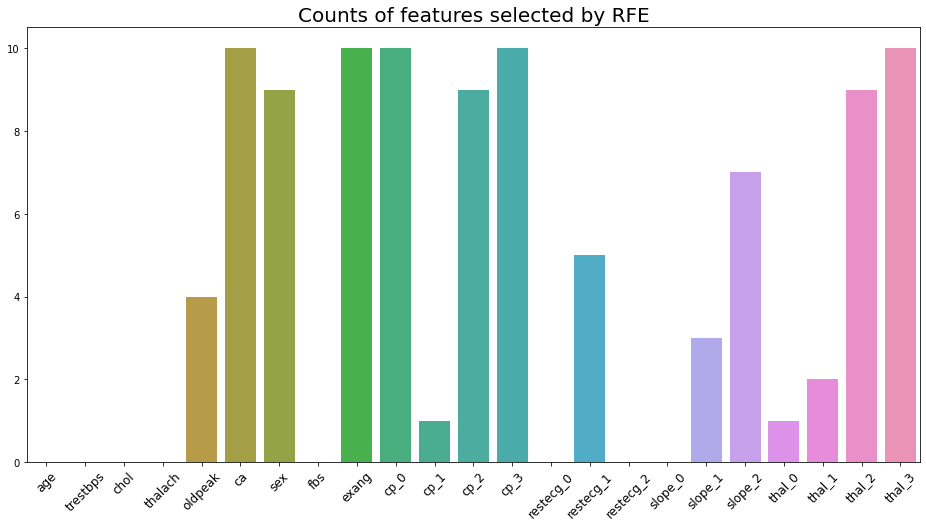

In [34]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8)) # Create a matplotlib subplots figure with 1 plot.
sns.barplot(data=pd.DataFrame(feat_counts.reshape((1,23)),
                              columns=feats_prepared.columns.values), ax=ax) # Plot a bar chart showing the number of times each feature was selected by RFE.
xlabels = ax.get_xticklabels() # Return tick labels (feature names) as an object so that they can be rotated.
ax.set_xticklabels(xlabels,rotation=45,fontsize=12) # Rotate x axis labels @ 45 degrees.
ax.set_title('Counts of features selected by RFE',fontsize=20) # Set major title of figure.

## Receiver Operating Characteristic for Linear SVM with RFE:

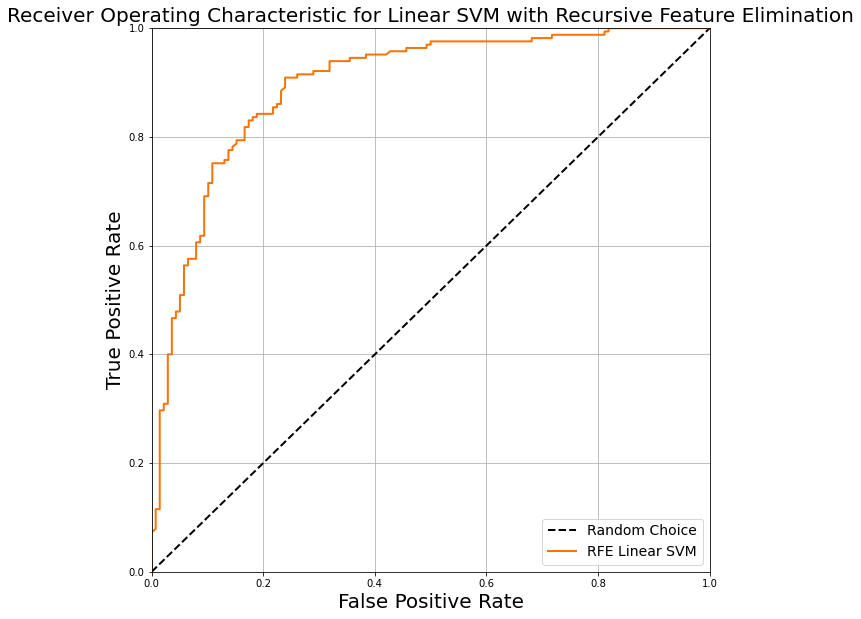

In [35]:
fpr_RFE,tpr_RFE = plot_roc_curve(test_labels_saved,RFE_test_proba_preds,
                               'RFE Linear SVM',
                               'Receiver Operating Characteristic for Linear SVM with Recursive Feature Elimination',
                              'xkcd:orange')

## Confusion Matrix and Precision & Recall for RFE SVM:

Precision of classifier: 0.8166666666666667
Recall of classifier: 0.8909090909090909


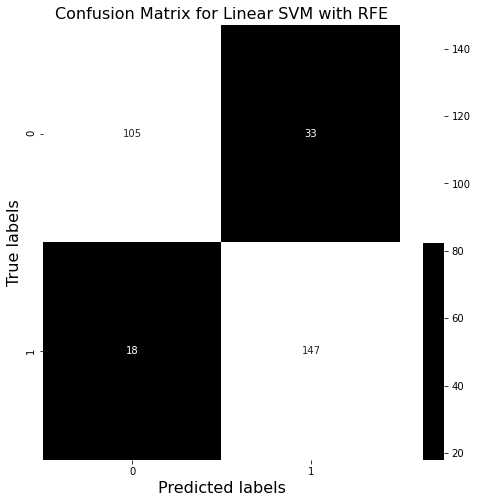

In [36]:
RFE_precision, RFE_recall = plot_conf_precision_recall(test_labels_saved,RFE_test_preds_saved,
                                                             "Confusion Matrix for Linear SVM with RFE")

## The Linear SVM with RFE achieved the following performance:

Mean AUC across 10 test folds: **0.89**

Standard deviation of AUC across 10 test folds: **0.05**

Mean accuracy across 10 test folds: **0.83**

Standard deviation of accuracy across 10 test folds: **0.06**

Precision: **82%**

Recall: **89%**

# 11. Discussion of Results

The results for the 4 models tested are shown in the table below.

| Model | Mean AUC | Std AUC | Mean Accuracy | Std Accuracy | Precision | Recall |
| :- | :-: | :-: | :-: | :-: | :-: | :-: |
| **Benchmark  Gaussian SVM** | 0.90 | 0.05 | 0.84 | 0.05 | 0.82 | 0.90 |
| **Gaussian SVM with univariate feature selection** | 0.91 | 0.04 | 0.85 | 0.05 | 0.83 | 0.91 |
| **Random Forest** | 0.91 | 0.04 | 0.84 | 0.07 | 0.83 | 0.88 |
| **Linear SVM with RFE** | 0.89 | 0.05 | 0.83 | 0.06 | 0.82 | 0.89 |

It must be said that there was no huge differences in the performance of the 4 models tested. The results of the benchmark SVM show that the SVM itself is fairly robust to noisey or uninformative features, and good performance is achieved without carrying out any kind of feature selection. It's worth noting that the linear SVM results with RFE could potentially be improved by carrying out a gridsearch on the regularisation hyperparameter `C` on the 9 training folds at each iteration of the 10-fold performance evaluation.

The similarity in results between all models is also clear from the plot of each model's ROC curve, shown below:

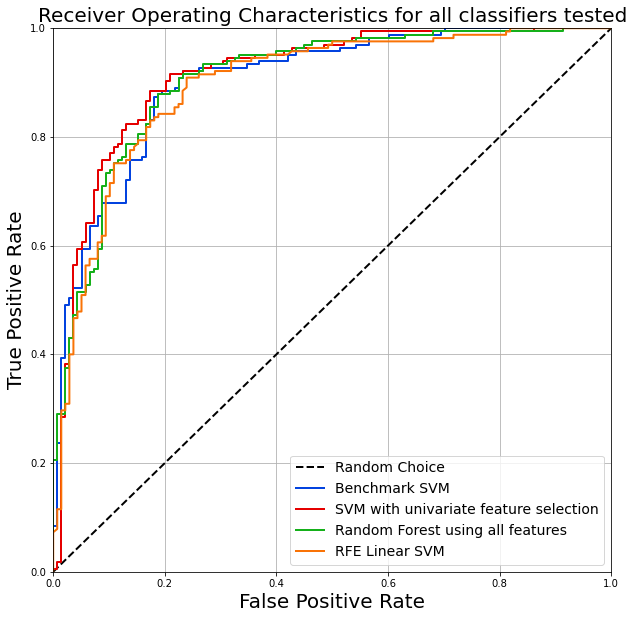

In [37]:
plt.figure(figsize=(10,10)) # Create matplotlib figure.
plt.plot([0,1],[0,1],linewidth=2,label='Random Choice',
         color='black',linestyle='dashed') # Plot the diagonal corresponding to an AUC of 0.5.
plt.plot(fpr_BM,tpr_BM, linewidth=2,label='Benchmark SVM',color='xkcd:blue') # Plot true pos rate against false pos rate.
plt.plot(fpr_univar,tpr_univar, linewidth=2,label='SVM with univariate feature selection',color='xkcd:red') # Plot true pos rate against false pos rate.
plt.plot(fpr_RF,tpr_RF, linewidth=2,label='Random Forest using all features',color='xkcd:green') # Plot true pos rate against false pos rate.
plt.plot(fpr_RFE,tpr_RFE, linewidth=2,label='RFE Linear SVM',color='xkcd:orange') # Plot true pos rate against false pos rate.
    
plt.legend(fontsize=14) # Create legend.
plt.xlabel('False Positive Rate',fontsize=20) # Set x-axis label.
plt.ylabel('True Positive Rate',fontsize=20) # Set y-axis label.
plt.xlim([0,1]) # Limit x-axis to range [0,1].
plt.ylim([0,1]) # Limit y-axis to range [0,1].
plt.title('Receiver Operating Characteristics for all classifiers tested',fontsize=20) # Set major title of ROC.
plt.grid() # Create gridlines.
plt.show()

The use of the 'Leave 30 Out'/10-fold performance evaluation reduces the risk that these models are performing similarly well by chance, or a lucky split - the results have shown that all 4 models generalise well across the entire dataset, which is the main benefit of using this computationally intensive testing method.

There was considerable overlap in the 10 best features selected by the 3 models utilising feature selection. The 10 features selected by each model are shown in the table below:

| Gaussian SVM with univariate feature selection | Random Forest | Linear SVM with RFE |
| -: | -: | -: |
| oldpeak | cp_0 | thal_3 |
| thalach | thal_3 | cp_3 |
| ca | ca | ca |
| exang | oldpeak | exang |
| cp_0 | thalach | cp_0 |
| cp_2 | thal_2 | sex |
| slope_1 | exang | thal_2 |
| slope_2 | slope_1 | cp_2 |
| thal_2 | age | slope_2 |
| thal_3 | slope_2 | restecg_1 |

The most overlap occurred between Random Forests and the Gaussian kernel SVM with univariate feature selection, with 9 overlapping features: This could be because when trees are being constructed in the Random Forest, each feature from the subset of features sampled by the tree is evaluated individually to split on at a given node - i.e. a process very similar to univariate feature selection is used to determine the best feature to split the data at each tree node.

Ultimately, if I were to select a model to deploy in a real system, it would have to be the Gaussian kernel SVM using univariate feature selection. It offered the best performance in terms of the AUC and accuracy across the 10 folds, and also offered a reduced variance (i.e. standard deviation)  in performance across the 10 folds, meaning it's more consistent in its predictions. As mentioned previously, the AUC is an important metric that quantifies how well the classifier is able to distinguish between the 2 classes. It also offers the best precision and recall. The precision of the classifiers is particularly important in the context of this problem. The precision was defined earlier as:

$Precision = \frac{TP}{TP+FP}$

Where *TP = True Positives* and *FP = False Positives*. For this problem, a healthy person was defined as the positive class, or label = 1. Therefore, we want to minimise the number of False Positives - people with heart disease who were incorrectly classified as being healthy. As a result, having a high precision is of utmost importance in this application, as we don't want someone at serious risk of heart disease to slip through the net. It's worth plotting the precision and recall curves for this classifier: this plot shows how the precision and recall of the classifier vary as the decision threshold is changed. There is a trade-off between precision and recall. If one goes up, generally the other goes down. We can use these curves to select a suitable trade-off between a high precision and a reasonable recall.

**Documentation for precision_recall_curve:** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

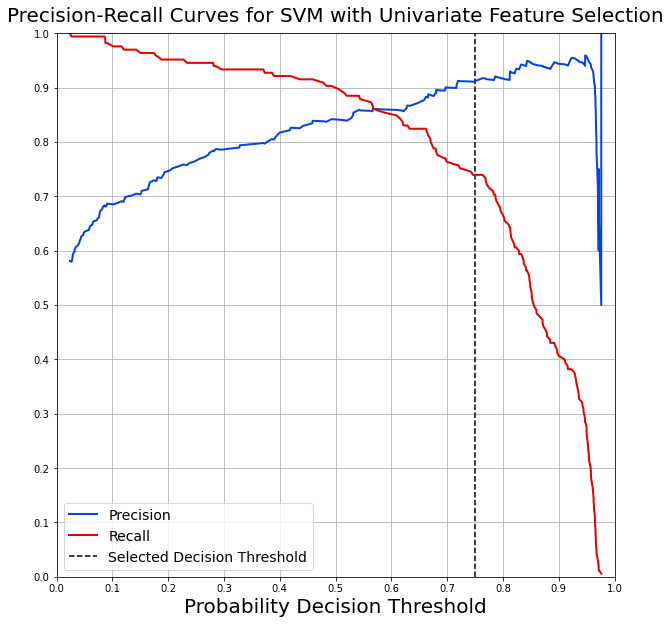

In [38]:
precisions,recalls,thresholds = precision_recall_curve(test_labels_saved,UVAR_test_proba_preds)
plt.figure(figsize=(10,10)) # Create matplotlib figure.

plt.plot(thresholds,precisions[:-1], linewidth=2,label='Precision',color='xkcd:blue') # Plot precision curves against thresholds used.
plt.plot(thresholds,recalls[:-1], linewidth=2,label='Recall',color='xkcd:red') # Plot recall curves against thresholds used.
plt.vlines(0.75,0,1.0,linestyle='dashed',label='Selected Decision Threshold') # Plot our choice of decision threshold.
plt.legend(fontsize=14) # Create legend.
plt.xlabel('Probability Decision Threshold',fontsize=20) # Set x-axis label.
plt.ylim([0,1]) # Limit y-axis to range [0,1].
plt.xlim([0,1]) # Limit x-axis to range [0,1].
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(0,1.1,0.1))
plt.title('Precision-Recall Curves for SVM with Univariate Feature Selection',fontsize=20,y=1.01) # Set major title of plot.
plt.grid() # Create gridlines.
plt.show()

Shown in the plot by the dashed line is a suitable choice of decision threshold at 0.75 (i.e. a probability score of greater than or equal to 0.75 from the classifier indicates the subject is healthy). This yields a precision of ~92% and a recall of approximately 75%. While the overall accuracy of the classifier will decrease, it ensures that approximately 92% of the subjects that are deemed 'healthy' by the classifier actually are healthy. Sure, it means that a few healthy patients may have to go through some further tests to confirm their result but the trade-off is that more patients that have heart disease receive appropriate attention.

The Gaussian kernel SVM using univariate feature selection also had a shorter training time than the benchmark SVM and the Random Forest. It's worth noting however that although it offered faster training times and reduced the dimensionality of the feature set, it would be tedious to add additional features to the feature set in order to improve the model - the process of checking for redundant features and analysing the correlation of the new features with the target label would have to be carried out again, whereas the benchmark SVM and Random Forest would not require this.